<a href="https://colab.research.google.com/github/justincharney/Python_Machine_Learning/blob/main/enamel_crack_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import os
import cv2
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

import torch
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [ ]:
!pip install -q segmentation-models-pytorch 
import segmentation_models_pytorch as smp
import torchvision.transforms.functional as TF
from tqdm import tqdm

     |████████████████████████████████| 87 kB 4.1 MB/s 
     |████████████████████████████████| 376 kB 17.4 MB/s 
     |████████████████████████████████| 58 kB 7.6 MB/s 


In [ ]:
!pip install -q optuna
import optuna

     |████████████████████████████████| 302 kB 12.7 MB/s 
     |████████████████████████████████| 80 kB 8.1 MB/s 
     |████████████████████████████████| 164 kB 67.8 MB/s 
     |████████████████████████████████| 75 kB 3.9 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 141 kB 71.1 MB/s 
     |████████████████████████████████| 111 kB 65.3 MB/s 


In [ ]:
!pip install -q torch-lr-finder
from torch_lr_finder import LRFinder

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path = Path('/content/drive/My Drive/Colab Notebooks/Segmentation Tooth Cracks')

In [ ]:
image_dir= path/"Training Images"
mask_dir = path/"Training Masks"

valid_image_dir = path/"Validation Images"
valid_mask_dir = path/"Validation Masks"

In [ ]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

In [ ]:
def pad_to_size(numToRound, multiple=32):
  remainder = numToRound % multiple
  if remainder == 0:
    return numToRound
  else:
    return int(numToRound + multiple - remainder)

In [ ]:
class SegmentationDataset(torch.utils.data.Dataset):

  def __init__(self,
               images_dir,
               masks_dir,
               augmentation=None,
               preprocessing=None):
    
    self.image_names = sorted(images_dir.glob('*'))
    self.mask_names = sorted(masks_dir.glob('*'))

    self.augmentation = augmentation
    self.preprocessing = preprocessing

  def __getitem__(self, i):
        
        # read images and masks
        image_path = self.image_names[i]
        mask_path = self.mask_names[i]

        with open(image_path, "rb") as image_file, open(mask_path,"rb") as mask_file:
           image = Image.open(image_file)
           image = image.convert("RGB")

           mask = Image.open(mask_file)
           mask = mask.convert("RGB")

           if self.augmentation:
            image, mask  = self.augmentation(image, mask)

           #sample = {"image": image, "mask": mask}
        return image, mask

  def __len__(self):
     # return length of 
      return len(self.image_names)

In [ ]:
class TestDataset(torch.utils.data.Dataset):

  def __init__(self,
               images_dir,
               augmentation=None):
    
    self.image_names = sorted(images_dir.glob('*'))

    self.augmentation = augmentation

  def __getitem__(self, i):
        
        # read images and masks
        image_path = self.image_names[i]

        with open(image_path, "rb") as image_file:
           image = Image.open(image_file)
           image = image.convert("RGB")

           #pad images to multiples of 32
           w, h = image.size
           h_pad = int((pad_to_size(h) - h)/2) 
           w_pad = int((pad_to_size(w) - w)/2) 
           padding = (w_pad, h_pad, w_pad, h_pad)
           
           image = TF.pad(image, padding)
          
           if self.augmentation:
            image = self.augmentation(image)
          
        return image

  def __len__(self):
     # return length of 
      return len(self.image_names)

In [ ]:
def transform(image, mask):
        # # Resize
        # resize = transforms.Resize(size=(1330, 1330))
        # image = resize(image)
        # mask = resize(mask)

        # # Random crop
        # i, j, h, w = transforms.RandomCrop.get_params(
        #     image, output_size=(512, 512))
        # image = TF.crop(image, i, j, h, w)
        # mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        #if random.random() > 0.5:
            #image = TF.hflip(image)
            #mask = TF.hflip(mask)

        # Random vertical flipping
        #if random.random() > 0.5:
            #image = TF.vflip(image)
            #mask = TF.vflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

def test_transform(image):
  image = TF.to_tensor(image)
  return image

##Dataloading/Visualization

In [ ]:
dataset = SegmentationDataset(image_dir, mask_dir)

random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

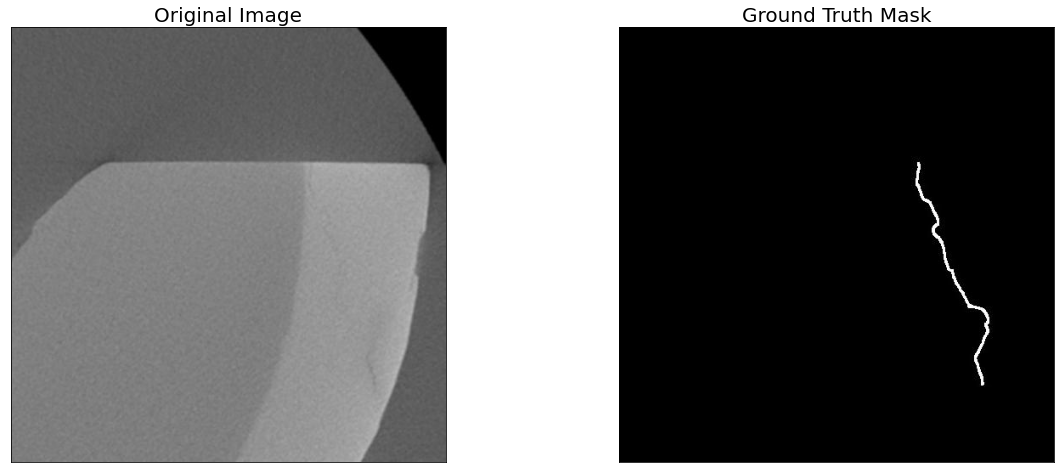

In [ ]:
visualize(
    original_image = image,
    ground_truth_mask = mask
)

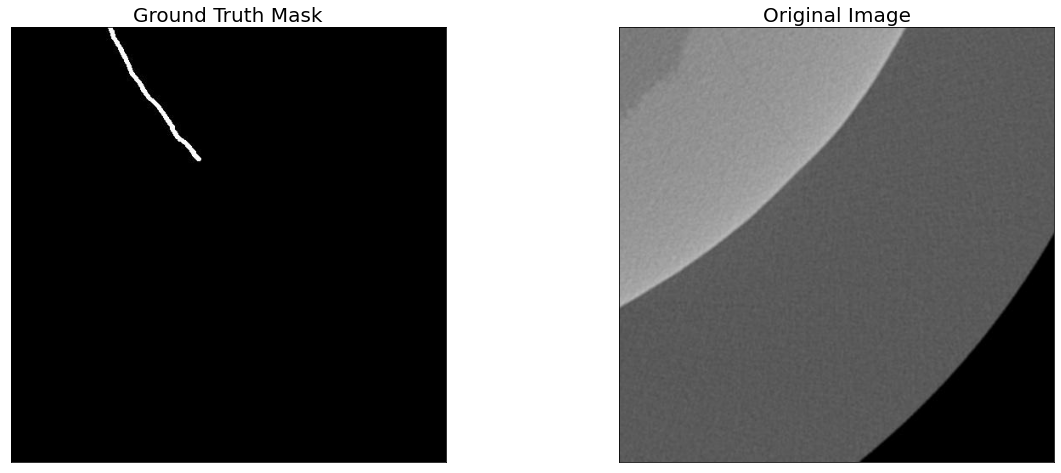

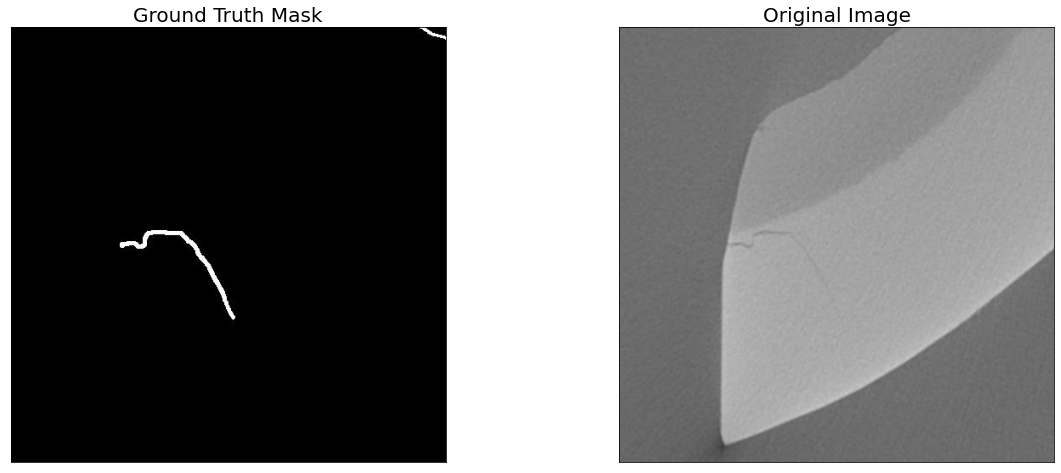

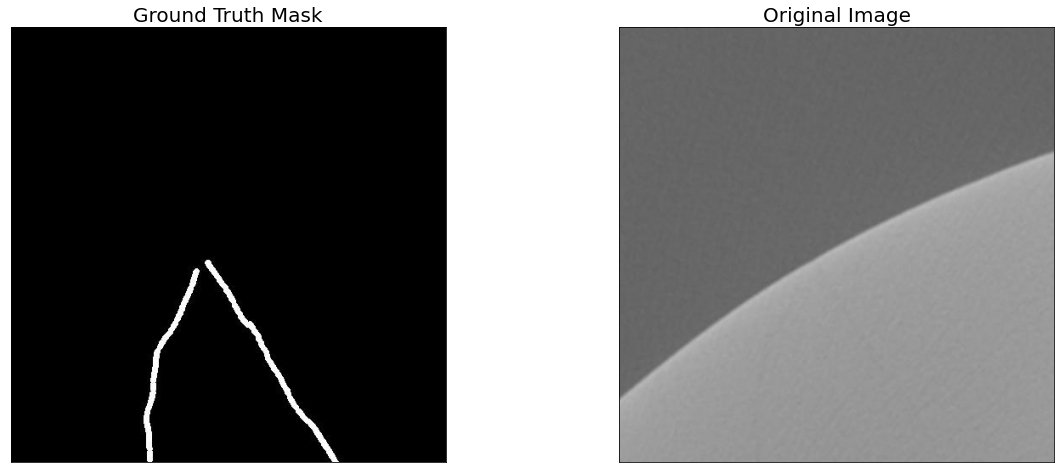

In [ ]:
augmented_dataset = SegmentationDataset(image_dir, mask_dir, augmentation=transform)


for i in range(3):
  random_idx = random.randint(0, len(augmented_dataset)-1)
  image, mask = augmented_dataset[random_idx]
  visualize(ground_truth_mask = transforms.ToPILImage()(mask),
            original_image = transforms.ToPILImage()(image))
  

In [ ]:
ENCODER = 'timm-regnetx_040'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ["Crack"]
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.MAnet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

#preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_040-73c2a654.pth" to /root/.cache/torch/hub/checkpoints/regnetx_040-73c2a654.pth


In [ ]:
train_dataset = SegmentationDataset(
    image_dir, 
    mask_dir,
    augmentation = transform,
    preprocessing = None
)

valid_dataset = SegmentationDataset(
    valid_image_dir,
    valid_mask_dir,
    augmentation = transform  
)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=5, shuffle=True, num_workers=4)


In [ ]:
ALPHA = 0.36
BETA = 1-ALPHA
GAMMA = 3

import torch.nn.functional as F



class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        #inputs = inputs.view(-1)
        #targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

    def __name__(self):
      return "Focal_Tversky_Loss"


In [ ]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 50

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = FocalTverskyLoss() #smp.utils.losses.DiceLoss()
# loss = FocalLoss()

# define metrics
metrics = [smp.utils.metrics.Fscore()
    #smp.utils.metrics.IoU(threshold=0.5,activation='sigmoid'),
    ]

# define optimizer
# optimizer = torch.optim.Adam([ 
#     dict(params=model.parameters(), lr=1e-4),
# ])

optimizer = torch.optim.Adamax([ 
    # dict(params=model.parameters(), lr=1e-4),
    dict(params=model.parameters(), lr=4.53e-2),
    # dict(params=model.parameters(), lr=1e-5),
])


In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss = loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.53E-02


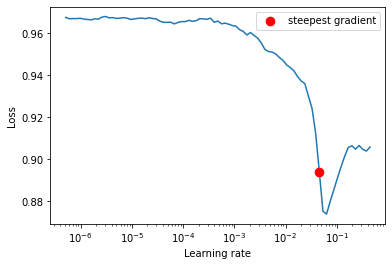

In [ ]:
#find the best learning rate for the model
lr_finder = LRFinder(model, optimizer,loss,DEVICE)
lr_finder.range_test(train_loader, end_lr=1, num_iter=100)
lr_finder.plot()
lr_finder.reset()

In [ ]:
import torch.optim as optim

In [ ]:
def objective(trial):

  model_name = trial.suggest_categorical("model", ["UnetPlusPlus", "PSPNet", 'MAnet'])
  ENCODER = trial.suggest_categorical("encoder", [ "resnet34", "timm-regnetx_040", "efficientnet-b3", "mobilenet_v2"])
  model = getattr(smp, model_name)(encoder_name=ENCODER, 
    encoder_weights='imagenet', 
    classes=len(CLASSES), 
    activation=ACTIVATION)

  #model = smp.f'{model_name}'(
    #encoder_name=ENCODER, 
    #encoder_weights=ENCODER_WEIGHTS, 
    #classes=len(CLASSES), 
    #activation=ACTIVATION,
#)
  

  ALPHA = trial.suggest_float("alpha", 0.3, 0.7)
  BETA = 1-ALPHA
  GAMMA = trial.suggest_int("gamma", 1, 3)

  loss = FocalTverskyLoss()

  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "AdamW", "Adamax"])
  lr = 1e-3

  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

  train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True)

  valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss = loss,
    metrics = metrics,
    device=DEVICE,
    verbose=True)
  
  if TRAINING:

    best_f_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        if valid_logs['fscore'] > best_f_score:
          best_f_score = valid_logs['fscore']

        trial.report(best_f_score, i)

        if trial.should_prune():
          raise optuna.exceptions.TrialPruned()

  return best_f_score #we want to maximize this metric

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction="maximize", pruner=optuna.pruners.MedianPruner(n_startup_trials=5)) #pruner=optuna.pruners.PatientPruner(wrapped_pruner=optuna.pruners.MedianPruner, patience=15))
study.optimize(objective, n_trials=100)

[I 2021-08-07 22:44:33,562] A new study created in memory with name: no-name-dc1a6030-557c-4ba9-aec1-d16e00dd40d9



Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 11.42it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9701, fscore - 0.08921]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 11.30it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.8333, fscore - 0.7181]

Epoch: 2
valid: 100%|██████████| 14/14 [00:01<00:00, 11.11it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.4648, fscore - 1.018]

Epoch: 3
valid: 100%|██████████| 14/14 [00:01<00:00, 11.38it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3303, fscore - 1.08]

Epoch: 4
valid: 100%|██████████| 14/14 [00:01<00:00, 11.28it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.2883, fscore - 1.119]

Epoch: 5
valid: 100%|██████████| 14/14 [00:01<00:00, 11.45it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.2671, fscore - 1.129]

Epoch: 6
valid: 100%|██████████| 14/14 [00:01<00:00, 11.05it/s, <bound me

[I 2021-08-07 22:46:09,284] Trial 0 finished with value: 1.1285673507622311 and parameters: {'model': 'MAnet', 'encoder': 'mobilenet_v2', 'alpha': 0.42977411067706756, 'gamma': 2, 'optimizer': 'Adamax'}. Best is trial 0 with value: 1.1285673507622311.




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 13.97it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.5484, fscore - 0.6988]

Epoch: 1
valid: 100%|██████████| 14/14 [00:00<00:00, 14.17it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.4453, fscore - 0.8921]

Epoch: 2
valid: 100%|██████████| 14/14 [00:00<00:00, 14.52it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.419, fscore - 0.9447]

Epoch: 3
valid: 100%|██████████| 14/14 [00:00<00:00, 14.49it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3964, fscore - 0.959]

Epoch: 4
valid: 100%|██████████| 14/14 [00:00<00:00, 14.74it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3772, fscore - 0.9797]

Epoch: 5
valid: 100%|██████████| 14/14 [00:00<00:00, 14.40it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3804, fscore - 0.9588]

Epoch: 6
valid: 100%|██████████| 14/14 [00:00<00:00, 14.32it/s, <bound

[I 2021-08-07 22:47:10,276] Trial 1 finished with value: 0.9867299305541174 and parameters: {'model': 'PSPNet', 'encoder': 'timm-regnetx_040', 'alpha': 0.5306203728843164, 'gamma': 2, 'optimizer': 'Adamax'}. Best is trial 0 with value: 1.1285673507622311.




Epoch: 0
valid: 100%|██████████| 14/14 [00:02<00:00,  6.70it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9384, fscore - 0.2724]

Epoch: 1
valid: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9959, fscore - 7.234e-12]

Epoch: 2
valid: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.7355, fscore - 0.3843]

Epoch: 3
valid: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.4039, fscore - 0.886]

Epoch: 4
valid: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.5299, fscore - 0.6727]

Epoch: 5
valid: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.4835, fscore - 0.7434]

Epoch: 6
valid: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, <b

[I 2021-08-07 22:50:36,584] Trial 2 finished with value: 1.0514226385525294 and parameters: {'model': 'UnetPlusPlus', 'encoder': 'efficientnet-b3', 'alpha': 0.44015012312707785, 'gamma': 1, 'optimizer': 'Adam'}. Best is trial 0 with value: 1.1285673507622311.




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 12.89it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9999, fscore - 7.156e-12]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 12.52it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9999, fscore - 7.426e-12]

Epoch: 2
valid: 100%|██████████| 14/14 [00:01<00:00, 12.25it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9999, fscore - 7.17e-12]

Epoch: 3
valid: 100%|██████████| 14/14 [00:01<00:00, 12.09it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9999, fscore - 7.119e-12]

Epoch: 4
valid: 100%|██████████| 14/14 [00:01<00:00, 12.68it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9999, fscore - 7.164e-12]

Epoch: 5
valid: 100%|██████████| 14/14 [00:01<00:00, 13.00it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9999, fscore - 7.158e-12]

Epoch: 6
valid: 100%|██████████| 14/14 [00:01<00:00

[I 2021-08-07 22:51:53,787] Trial 3 finished with value: 7.888019989792106e-12 and parameters: {'model': 'PSPNet', 'encoder': 'efficientnet-b3', 'alpha': 0.41286870656952257, 'gamma': 1, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 1.1285673507622311.




Epoch: 0
valid: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.932, fscore - 0.1781]

Epoch: 1
valid: 100%|██████████| 14/14 [00:02<00:00,  6.67it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.7111, fscore - 0.4876]

Epoch: 2
valid: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.6738, fscore - 0.4531]

Epoch: 3
valid: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.7292, fscore - 0.3683]

Epoch: 4
valid: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.598, fscore - 0.5648]

Epoch: 5
valid: 100%|██████████| 14/14 [00:02<00:00,  6.71it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3246, fscore - 1.034]

Epoch: 6
valid: 100%|██████████| 14/14 [00:02<00:00,  6.66it/s, <bound 

[I 2021-08-07 22:55:20,046] Trial 4 finished with value: 1.034425092594964 and parameters: {'model': 'UnetPlusPlus', 'encoder': 'efficientnet-b3', 'alpha': 0.3246629068567864, 'gamma': 2, 'optimizer': 'Adam'}. Best is trial 0 with value: 1.1285673507622311.




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 11.02it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.8567, fscore - 0.6115]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 10.82it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3978, fscore - 0.902]

Epoch: 2
valid: 100%|██████████| 14/14 [00:01<00:00, 10.58it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.5162, fscore - 0.7721]

Epoch: 3
valid: 100%|██████████| 14/14 [00:01<00:00, 10.53it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.2796, fscore - 1.077]

Epoch: 4
valid: 100%|██████████| 14/14 [00:01<00:00, 10.81it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3899, fscore - 0.9351]

Epoch: 5
valid: 100%|██████████| 14/14 [00:01<00:00, 10.74it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.2864, fscore - 1.058]

Epoch: 6
valid: 100%|██████████| 14/14 [00:01<00:00, 10.85it/s, <bound 

[I 2021-08-07 22:57:02,941] Trial 5 finished with value: 1.1353309580257958 and parameters: {'model': 'UnetPlusPlus', 'encoder': 'mobilenet_v2', 'alpha': 0.46553606263363845, 'gamma': 3, 'optimizer': 'Adam'}. Best is trial 5 with value: 1.1353309580257958.




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00,  7.48it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9806, fscore - 0.1122]

[I 2021-08-07 22:57:28,674] Trial 6 pruned. 




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 11.56it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.8128, fscore - 0.4605]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 11.37it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3966, fscore - 0.9048]

Epoch: 2
valid: 100%|██████████| 14/14 [00:01<00:00, 11.48it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3817, fscore - 0.9286]

Epoch: 3
valid: 100%|██████████| 14/14 [00:01<00:00, 11.13it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3367, fscore - 0.9864]

Epoch: 4
valid: 100%|██████████| 14/14 [00:01<00:00, 11.18it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.5035, fscore - 0.7]

Epoch: 5
valid: 100%|██████████| 14/14 [00:01<00:00, 11.21it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3413, fscore - 0.9876]

[I 2021-08-07 22:58:50,017] Trial 7 pruned. 




Epoch: 0
valid: 100%|██████████| 14/14 [00:02<00:00,  6.28it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.8773, fscore - 0.5329]

Epoch: 1
valid: 100%|██████████| 14/14 [00:02<00:00,  6.30it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.4961, fscore - 0.7667]

Epoch: 2
valid: 100%|██████████| 14/14 [00:02<00:00,  6.26it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3457, fscore - 0.9792]

Epoch: 3
valid: 100%|██████████| 14/14 [00:02<00:00,  6.24it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3747, fscore - 0.9088]

Epoch: 4
valid: 100%|██████████| 14/14 [00:02<00:00,  6.34it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.4563, fscore - 0.8169]

Epoch: 5
valid: 100%|██████████| 14/14 [00:02<00:00,  6.38it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.4225, fscore - 0.8359]

[I 2021-08-07 23:01:57,154] Trial 8 pruned. 




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 12.36it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9451, fscore - 0.07205]

[I 2021-08-07 23:02:08,467] Trial 9 pruned. 




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00,  7.42it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.7282, fscore - 0.4597]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00,  7.34it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.7512, fscore - 0.344]

[I 2021-08-07 23:02:56,164] Trial 10 pruned. 




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 11.08it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9498, fscore - 0.3568]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 10.77it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.7417, fscore - 0.9047]

Epoch: 2
valid: 100%|██████████| 14/14 [00:01<00:00, 11.32it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.4345, fscore - 1.006]

Epoch: 3
valid: 100%|██████████| 14/14 [00:01<00:00, 11.16it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3398, fscore - 1.04]

Epoch: 4
valid: 100%|██████████| 14/14 [00:01<00:00, 11.46it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.2915, fscore - 1.096]

Epoch: 5
valid: 100%|██████████| 14/14 [00:01<00:00, 10.85it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.288, fscore - 1.088]

Epoch: 6
valid: 100%|██████████| 14/14 [00:01<00:00, 11.10it/s, <bound met

[I 2021-08-07 23:04:32,395] Trial 11 finished with value: 1.1501524788992745 and parameters: {'model': 'MAnet', 'encoder': 'mobilenet_v2', 'alpha': 0.3334700096217748, 'gamma': 3, 'optimizer': 'Adamax'}. Best is trial 11 with value: 1.1501524788992745.




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 11.11it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9504, fscore - 0.4199]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 11.16it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.7819, fscore - 0.8614]

Epoch: 2
valid: 100%|██████████| 14/14 [00:01<00:00, 10.87it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.4428, fscore - 0.9791]

Epoch: 3
valid: 100%|██████████| 14/14 [00:01<00:00, 11.23it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3503, fscore - 1.001]

Epoch: 4
valid: 100%|██████████| 14/14 [00:01<00:00, 11.50it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3041, fscore - 1.052]

Epoch: 5
valid: 100%|██████████| 14/14 [00:01<00:00, 11.42it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.2621, fscore - 1.14]

Epoch: 6
valid: 100%|██████████| 14/14 [00:01<00:00, 10.85it/s, <bound m

[I 2021-08-07 23:06:08,447] Trial 12 finished with value: 1.1400429819311413 and parameters: {'model': 'MAnet', 'encoder': 'mobilenet_v2', 'alpha': 0.30069415056102894, 'gamma': 3, 'optimizer': 'Adamax'}. Best is trial 11 with value: 1.1501524788992745.




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 11.41it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9491, fscore - 0.3254]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 11.29it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.7821, fscore - 0.8107]

Epoch: 2
valid: 100%|██████████| 14/14 [00:01<00:00, 11.41it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.4244, fscore - 0.9727]

Epoch: 3
valid: 100%|██████████| 14/14 [00:01<00:00, 11.09it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.339, fscore - 1.041]

Epoch: 4
valid: 100%|██████████| 14/14 [00:01<00:00, 11.05it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3208, fscore - 1.042]

Epoch: 5
valid: 100%|██████████| 14/14 [00:01<00:00, 11.23it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.2829, fscore - 1.105]

Epoch: 6
valid: 100%|██████████| 14/14 [00:01<00:00, 11.11it/s, <bound m

[I 2021-08-07 23:07:44,386] Trial 13 finished with value: 1.1050911716052463 and parameters: {'model': 'MAnet', 'encoder': 'mobilenet_v2', 'alpha': 0.3043607187101232, 'gamma': 3, 'optimizer': 'Adamax'}. Best is trial 11 with value: 1.1501524788992745.




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 11.39it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9587, fscore - 0.3483]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 10.98it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.8349, fscore - 0.8199]

Epoch: 2
valid: 100%|██████████| 14/14 [00:01<00:00, 10.99it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.5454, fscore - 0.9054]

[I 2021-08-07 23:08:25,990] Trial 14 pruned. 




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 10.91it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.8962, fscore - 0.638]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 10.85it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.5649, fscore - 0.8689]

Epoch: 2
valid: 100%|██████████| 14/14 [00:01<00:00, 10.90it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3658, fscore - 1.005]

Epoch: 3
valid: 100%|██████████| 14/14 [00:01<00:00, 10.66it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.4015, fscore - 0.8997]

Epoch: 4
valid: 100%|██████████| 14/14 [00:01<00:00, 10.44it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3039, fscore - 1.051]

Epoch: 5
valid: 100%|██████████| 14/14 [00:01<00:00, 10.62it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3102, fscore - 1.065]

[I 2021-08-07 23:09:49,101] Trial 15 pruned. 




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 11.16it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.6644, fscore - 0.4818]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 11.47it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.5277, fscore - 0.7773]

[I 2021-08-07 23:10:16,447] Trial 16 pruned. 




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 11.39it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.6704, fscore - 0.6346]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 11.31it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.4365, fscore - 0.8428]

Epoch: 2
valid: 100%|██████████| 14/14 [00:01<00:00, 11.23it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3462, fscore - 0.9828]

Epoch: 3
valid: 100%|██████████| 14/14 [00:01<00:00, 11.13it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3418, fscore - 0.9589]

[I 2021-08-07 23:11:11,444] Trial 17 pruned. 




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 10.97it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.938, fscore - 0.349]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 11.34it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.703, fscore - 0.9319]

Epoch: 2
valid: 100%|██████████| 14/14 [00:01<00:00, 11.30it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3897, fscore - 1.033]

Epoch: 3
valid: 100%|██████████| 14/14 [00:01<00:00, 10.96it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3105, fscore - 1.097]

Epoch: 4
valid: 100%|██████████| 14/14 [00:01<00:00, 11.03it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.2782, fscore - 1.104]

Epoch: 5
valid: 100%|██████████| 14/14 [00:01<00:00, 11.26it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.2734, fscore - 1.15]

Epoch: 6
valid: 100%|██████████| 14/14 [00:01<00:00, 11.19it/s, <bound metho

[I 2021-08-07 23:12:47,518] Trial 18 finished with value: 1.150314688682556 and parameters: {'model': 'MAnet', 'encoder': 'mobilenet_v2', 'alpha': 0.3094548974279563, 'gamma': 2, 'optimizer': 'Adamax'}. Best is trial 18 with value: 1.150314688682556.




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 10.74it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9344, fscore - 0.2978]

[I 2021-08-07 23:13:01,850] Trial 19 pruned. 




Epoch: 0
valid: 100%|██████████| 14/14 [00:00<00:00, 15.74it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.7824, fscore - 0.3078]

[I 2021-08-07 23:13:07,623] Trial 20 pruned. 




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 10.80it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9462, fscore - 0.3739]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 10.98it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.7894, fscore - 0.7989]

[I 2021-08-07 23:13:35,763] Trial 21 pruned. 




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 11.25it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.945, fscore - 0.6064]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 11.30it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.6621, fscore - 0.917]

Epoch: 2
valid: 100%|██████████| 14/14 [00:01<00:00, 10.89it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3714, fscore - 1.023]

Epoch: 3
valid: 100%|██████████| 14/14 [00:01<00:00, 10.89it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.2928, fscore - 1.104]

Epoch: 4
valid: 100%|██████████| 14/14 [00:01<00:00, 10.97it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.2747, fscore - 1.131]

Epoch: 5
valid: 100%|██████████| 14/14 [00:01<00:00, 11.17it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.2605, fscore - 1.14]

Epoch: 6
valid: 100%|██████████| 14/14 [00:01<00:00, 11.13it/s, <bound meth

[I 2021-08-07 23:15:11,722] Trial 22 finished with value: 1.1403093976633891 and parameters: {'model': 'MAnet', 'encoder': 'mobilenet_v2', 'alpha': 0.3058463837293755, 'gamma': 3, 'optimizer': 'Adamax'}. Best is trial 18 with value: 1.150314688682556.




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 10.85it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.8835, fscore - 0.5368]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 11.01it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.5352, fscore - 0.9149]

Epoch: 2
valid: 100%|██████████| 14/14 [00:01<00:00, 10.81it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.4289, fscore - 0.8855]

[I 2021-08-07 23:15:53,525] Trial 23 pruned. 




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 10.99it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.6607, fscore - 0.4894]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 11.37it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.7663, fscore - 0.312]

[I 2021-08-07 23:16:20,884] Trial 24 pruned. 




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 11.05it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.8607, fscore - 0.5577]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 11.28it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.4702, fscore - 0.8044]

[I 2021-08-07 23:16:48,682] Trial 25 pruned. 




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 11.00it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.949, fscore - 0.2682]

[I 2021-08-07 23:17:03,071] Trial 26 pruned. 




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 10.65it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9658, fscore - 0.436]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 10.79it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.8797, fscore - 0.6903]

[I 2021-08-07 23:17:31,285] Trial 27 pruned. 




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00,  7.66it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9386, fscore - 0.4511]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00,  7.49it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.6887, fscore - 0.9055]

Epoch: 2
valid: 100%|██████████| 14/14 [00:01<00:00,  7.56it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.3947, fscore - 1.012]

Epoch: 3
valid: 100%|██████████| 14/14 [00:01<00:00,  7.39it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.2993, fscore - 1.141]

Epoch: 4
valid: 100%|██████████| 14/14 [00:01<00:00,  7.53it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.2906, fscore - 1.101]

Epoch: 5
valid: 100%|██████████| 14/14 [00:01<00:00,  7.50it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.2854, fscore - 1.079]

Epoch: 6
valid: 100%|██████████| 14/14 [00:01<00:00,  7.37it/s, <bound m

[I 2021-08-07 23:20:26,176] Trial 28 finished with value: 1.1593299210071566 and parameters: {'model': 'MAnet', 'encoder': 'timm-regnetx_040', 'alpha': 0.361345618814054, 'gamma': 3, 'optimizer': 'Adamax'}. Best is trial 28 with value: 1.1593299210071566.




Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00, 13.43it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.5563, fscore - 0.6976]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00, 13.98it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.4772, fscore - 0.8376]

[I 2021-08-07 23:20:44,232] Trial 29 pruned. 




Epoch: 0
train:  71%|███████   | 44/62 [00:16<00:06,  2.61it/s, <bound method FocalTverskyLoss.__name__ of FocalTverskyLoss()> - 0.9641, fscore - 0.1505]


KeyboardInterrupt: ignored

In [ ]:
study.best_trial

FrozenTrial(number=28, values=[1.1593299210071566], datetime_start=datetime.datetime(2021, 8, 7, 23, 17, 31, 286802), datetime_complete=datetime.datetime(2021, 8, 7, 23, 20, 26, 175944), params={'model': 'MAnet', 'encoder': 'timm-regnetx_040', 'alpha': 0.361345618814054, 'gamma': 3, 'optimizer': 'Adamax'}, distributions={'model': CategoricalDistribution(choices=('UnetPlusPlus', 'PSPNet', 'MAnet')), 'encoder': CategoricalDistribution(choices=('resnet34', 'timm-regnetx_040', 'efficientnet-b3', 'mobilenet_v2')), 'alpha': UniformDistribution(high=0.7, low=0.3), 'gamma': IntUniformDistribution(high=3, low=1, step=1), 'optimizer': CategoricalDistribution(choices=('Adam', 'RMSprop', 'AdamW', 'Adamax'))}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.45111629579748425, 1: 0.9054677784442902, 2: 1.0117702952453067, 3: 1.1414276361465452, 4: 1.1414276361465452, 5: 1.1414276361465452, 6: 1.1593299210071566}, trial_id=28, state=TrialState.COMPLETE, value=None)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

##Training/Testing

In [ ]:
model_name = "model_2.pth"
model_path = f'/content/drive/My Drive/Colab Notebooks/Segmentation Tooth Cracks/{model_name}'

In [ ]:
if TRAINING:

    best_f_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_f_score < valid_logs['fscore']:
            best_f_score = valid_logs['fscore']
            torch.save(model, model_path) #could also upload to google drive
            print('Model saved!')

NameError: ignored

In [ ]:
best_model = torch.load(model_path)
print("Loaded from previous commit")

Loaded from previous commit


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
best_model.eval()
best_model.to(DEVICE)

MAnet(
  (encoder): RegNetEncoder(
    (stem): ConvBnAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (act): ReLU(inplace=True)
      )
    )
    (s1): RegStage(
      (b1): Bottleneck(
        (conv1): ConvBnAct(
          (conv): Conv2d(32, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (act): ReLU(inplace=True)
          )
        )
        (conv2): ConvBnAct(
          (conv): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
          (bn): BatchNormAct2d(
            80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (act): ReLU(inplace=True)
          )
        )
        (conv3): ConvBnAct(
          (conv): Conv2d(80, 80, kernel_size

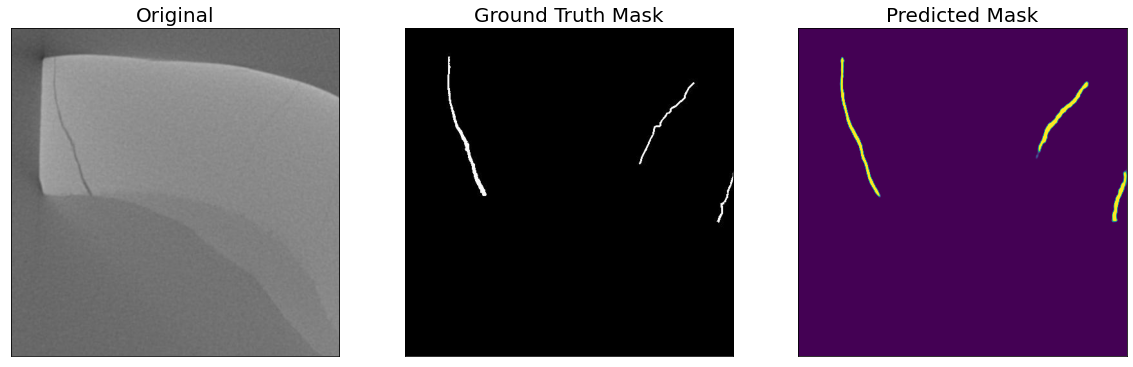

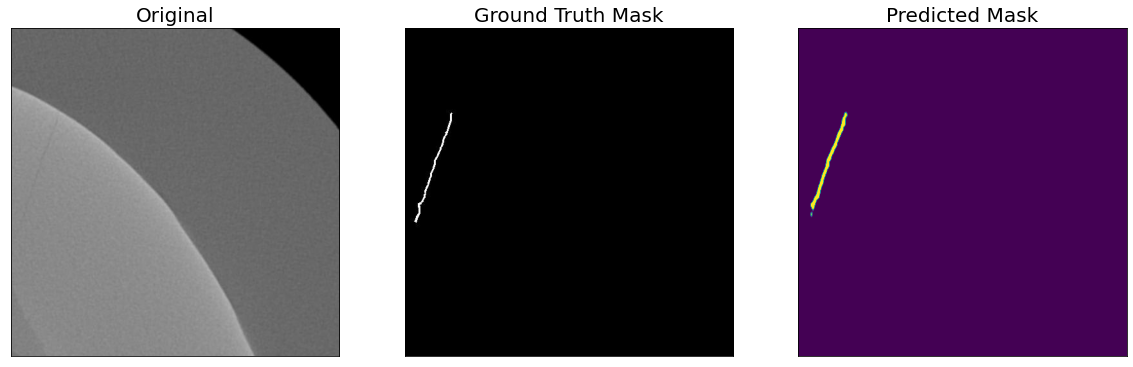

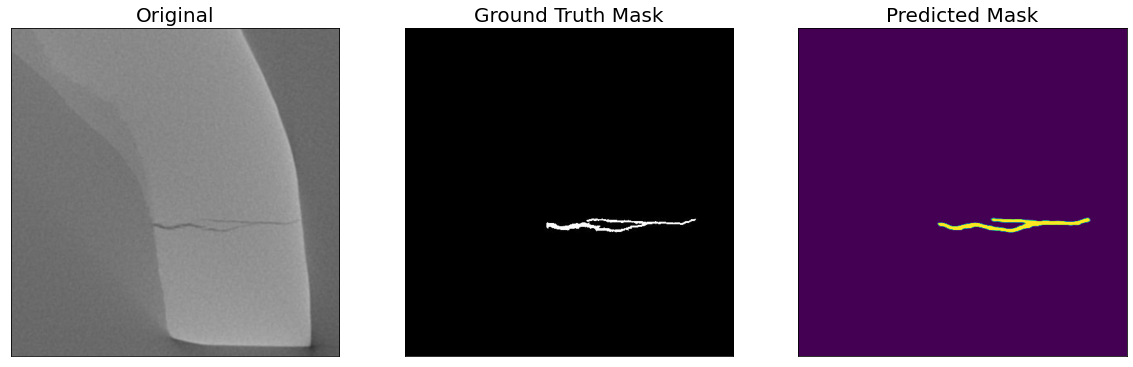

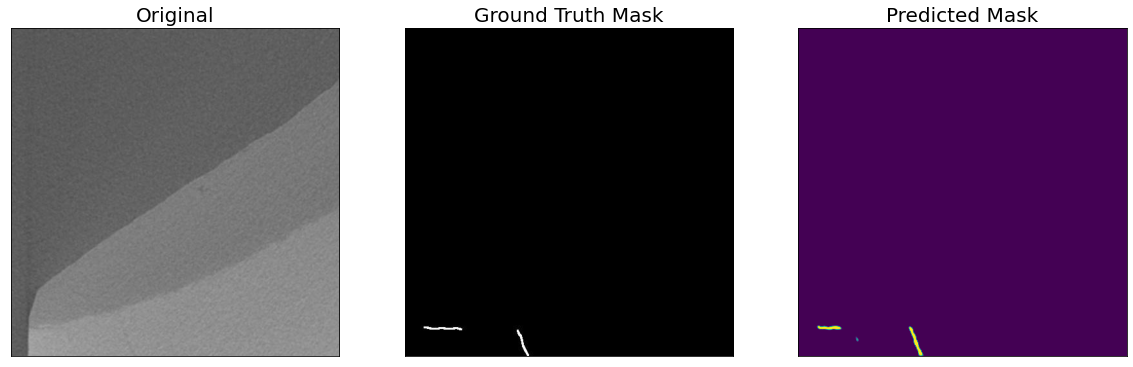

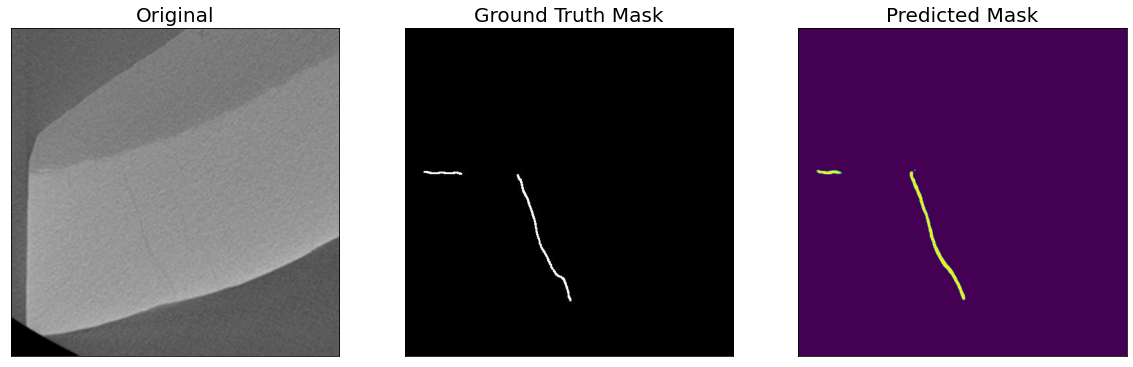

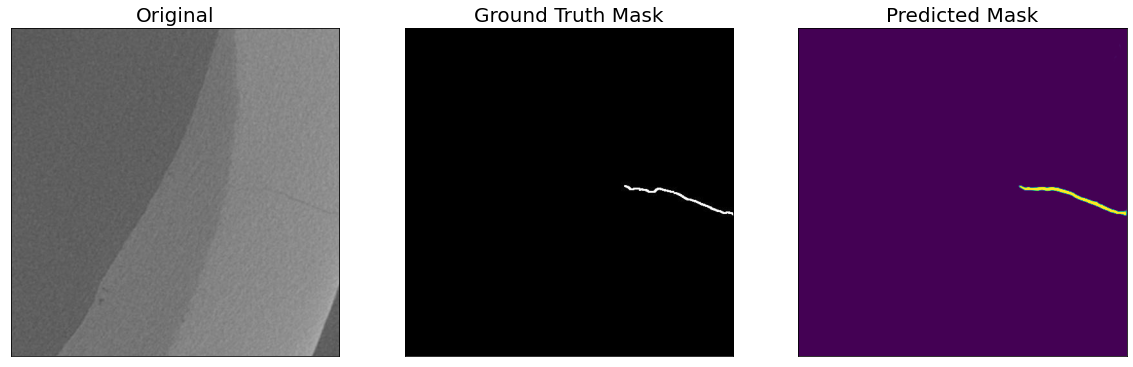

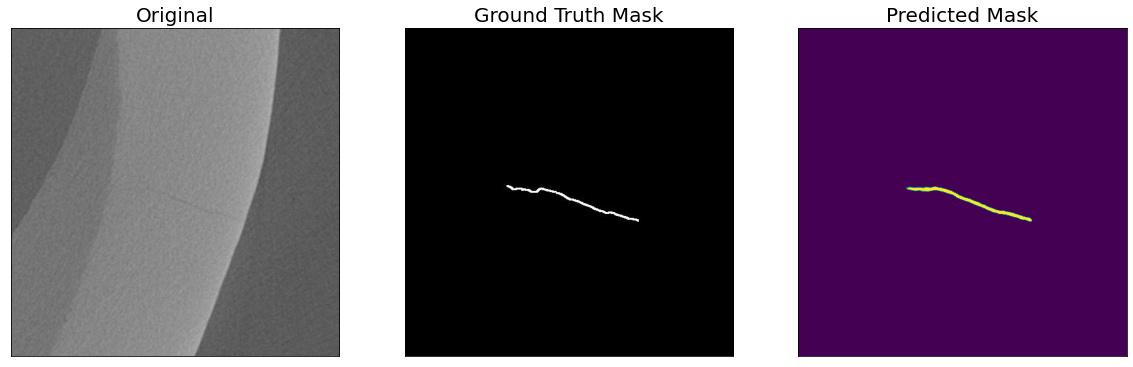

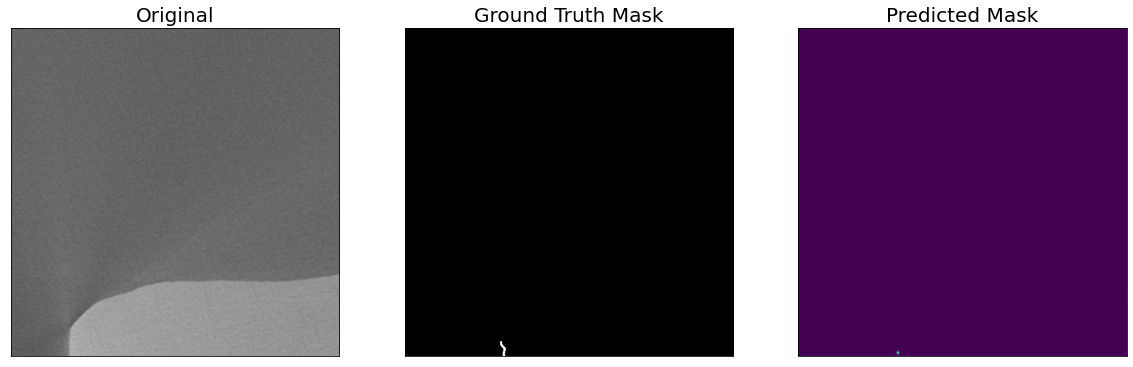

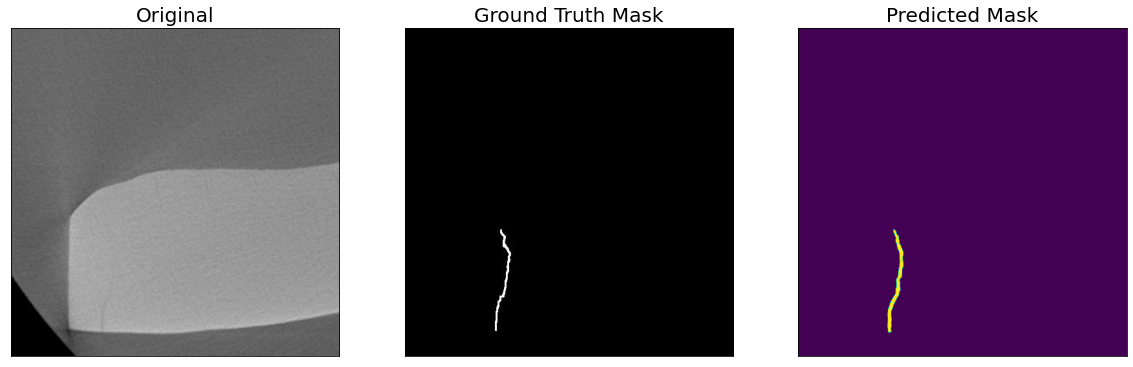

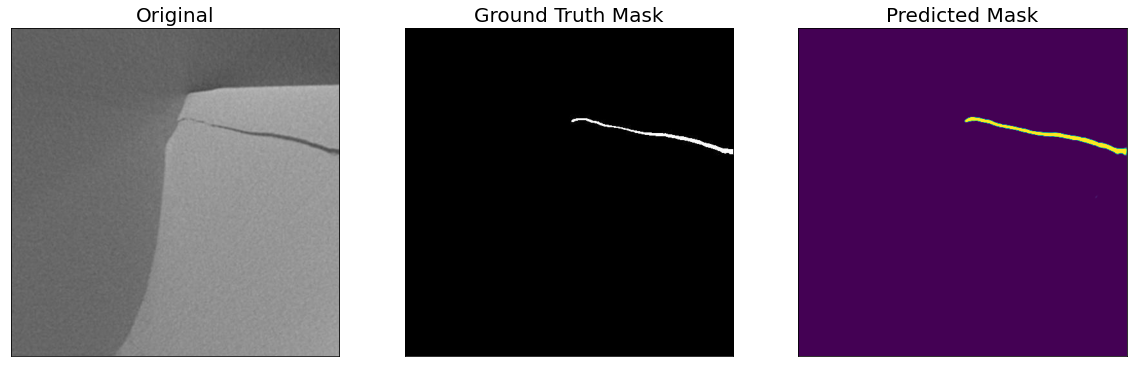

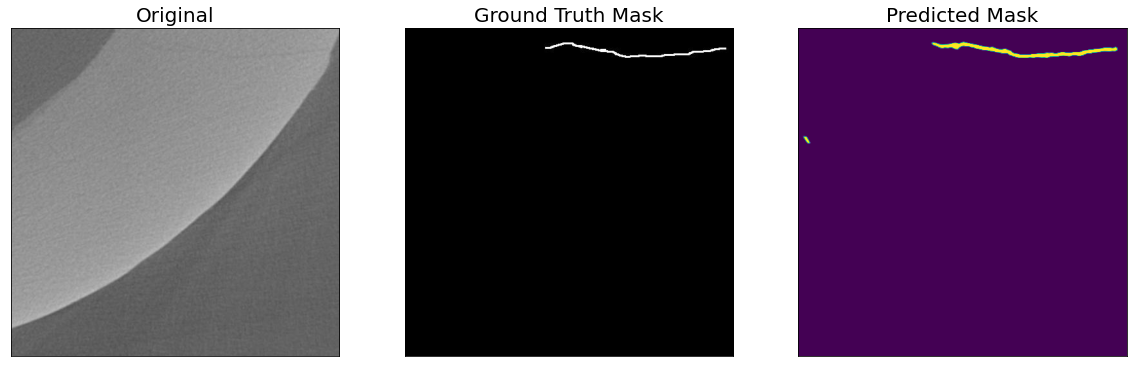

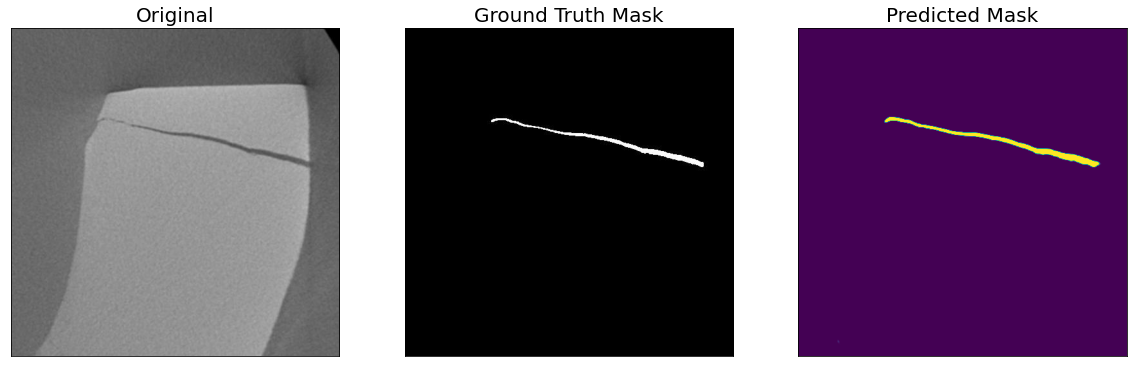

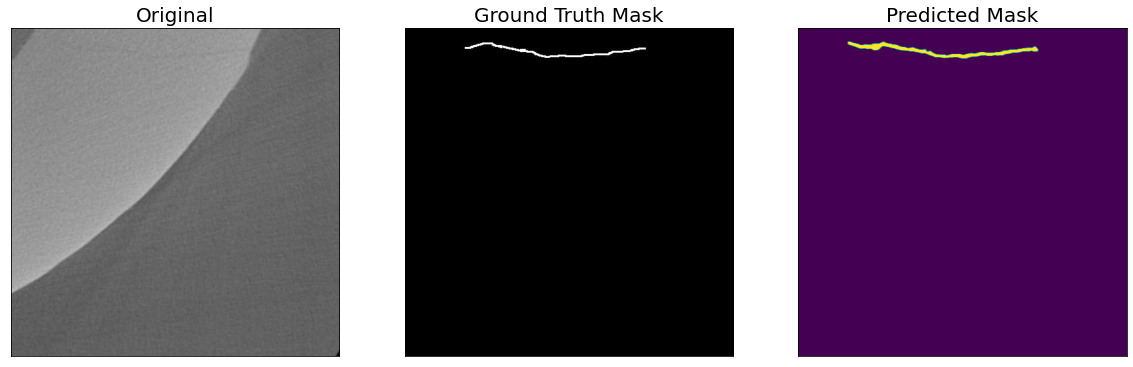

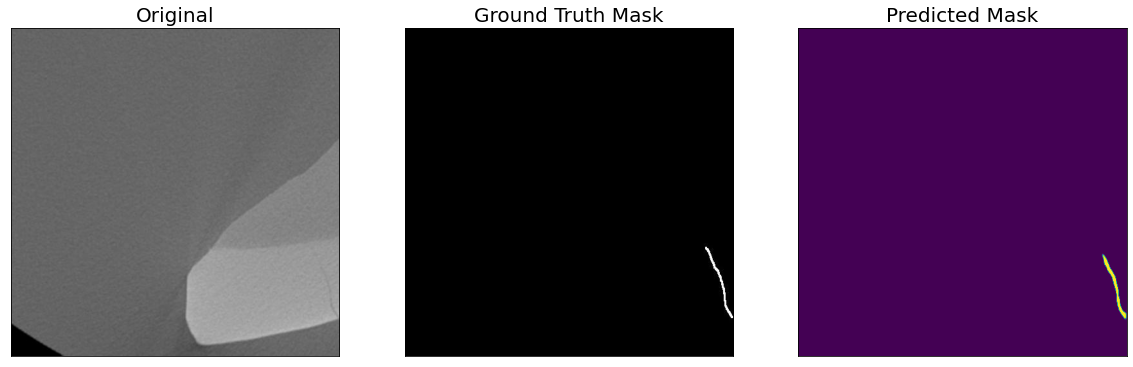

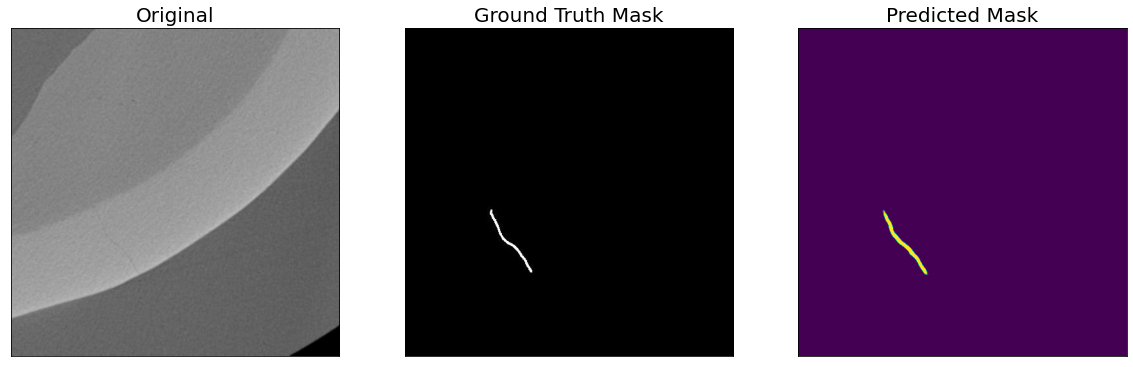

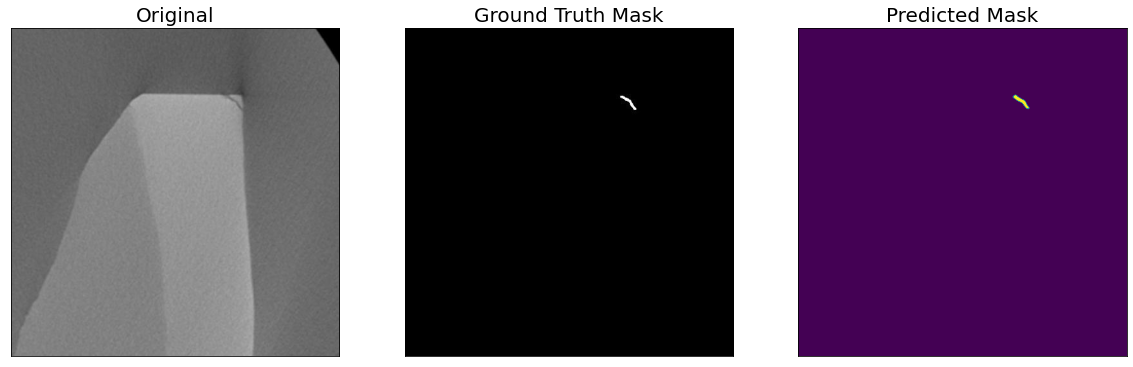

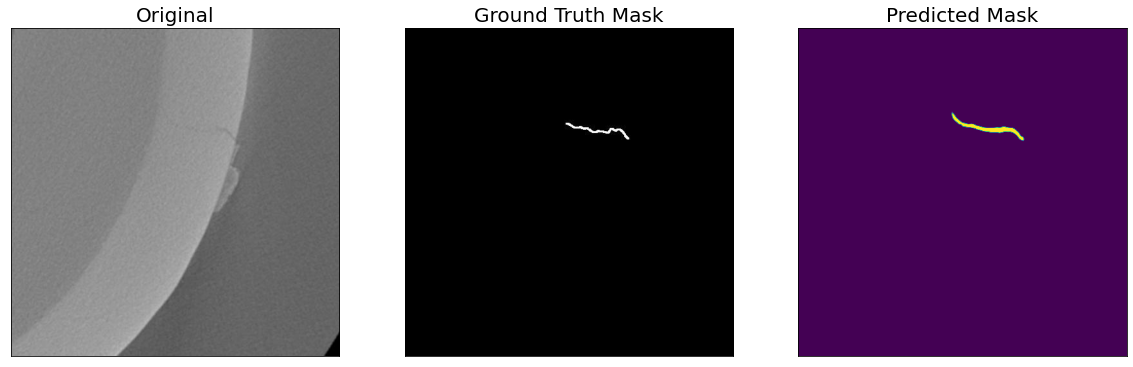

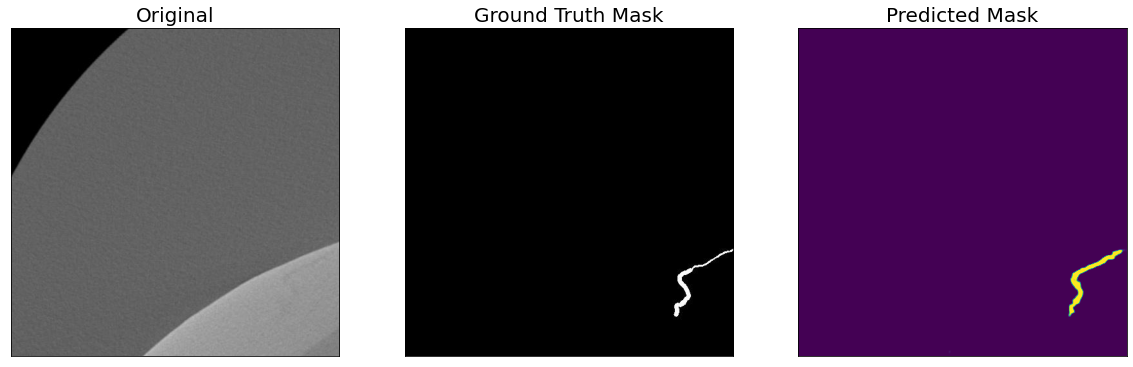

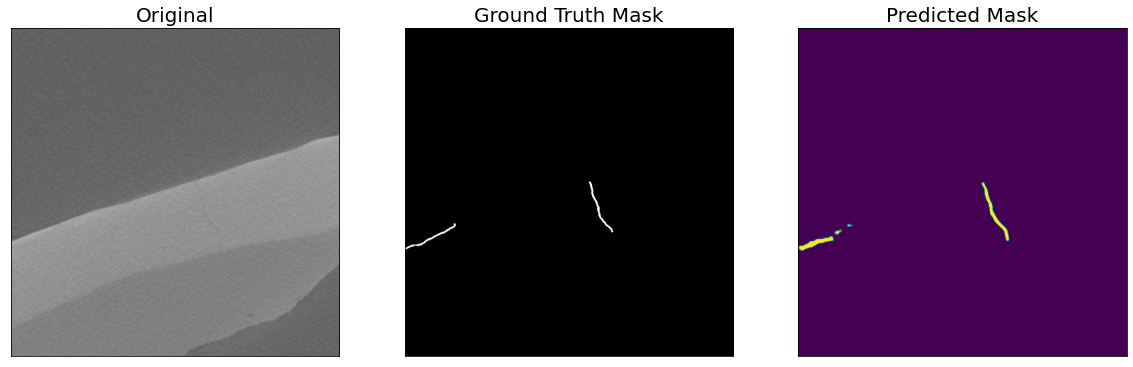

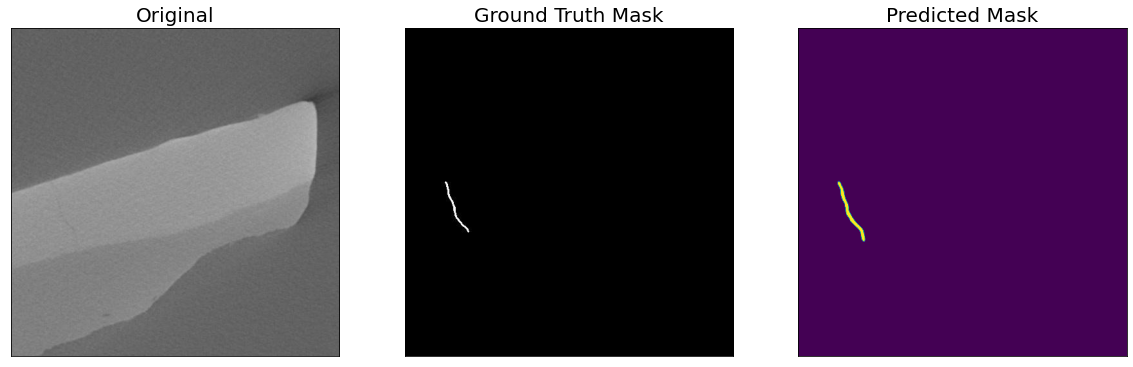

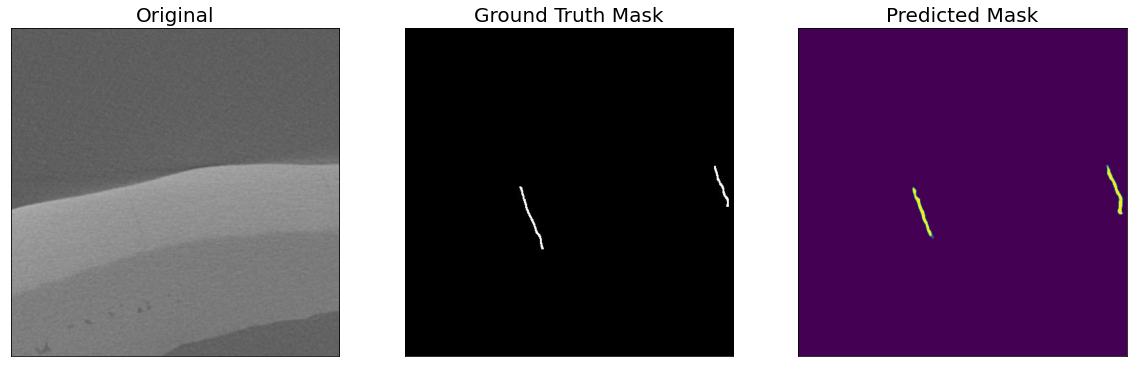

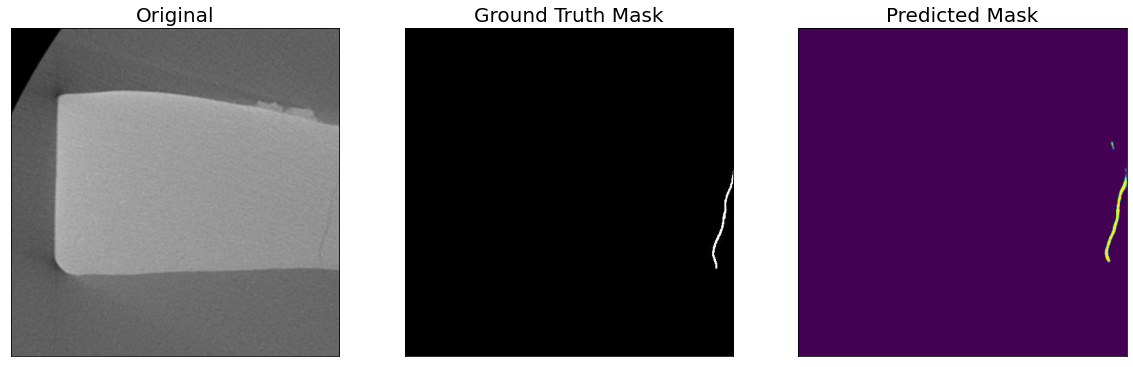

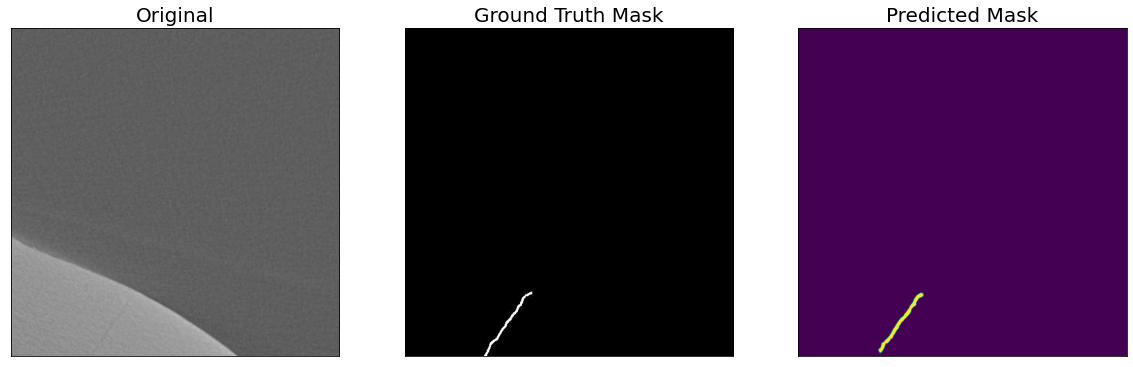

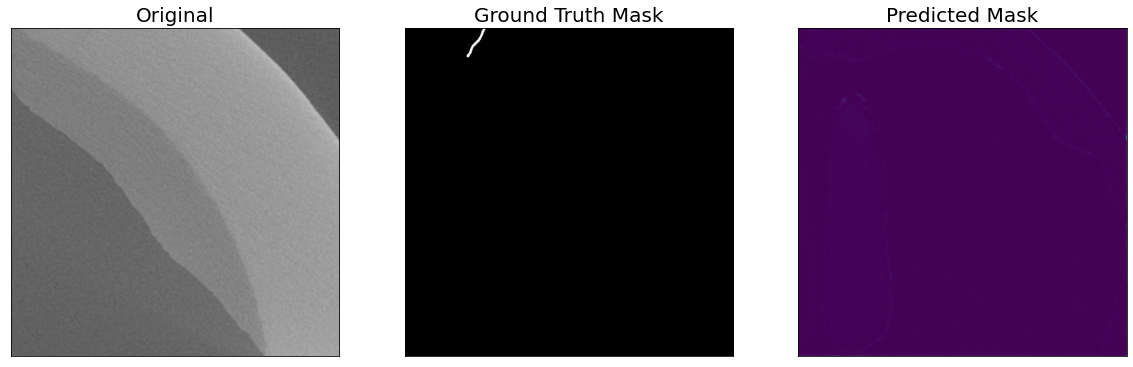

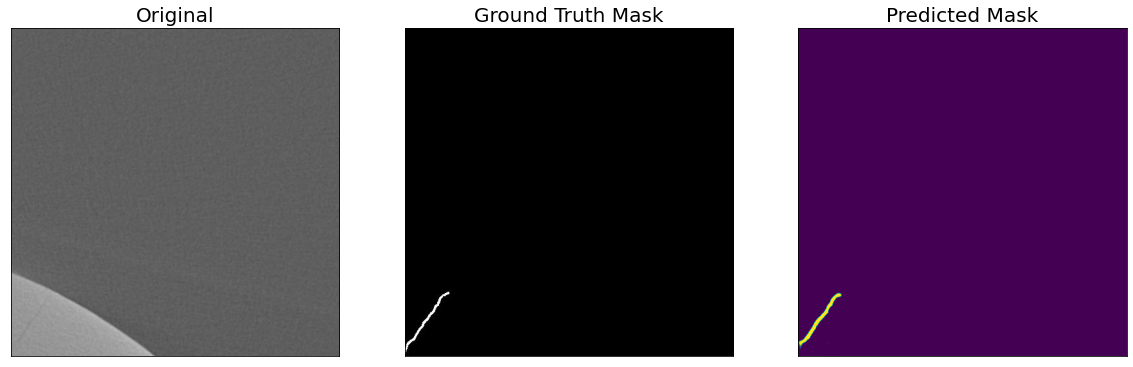

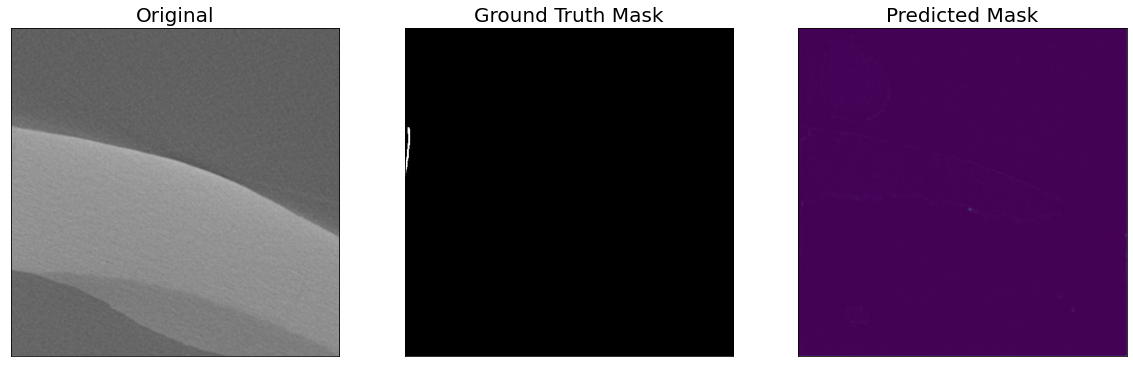

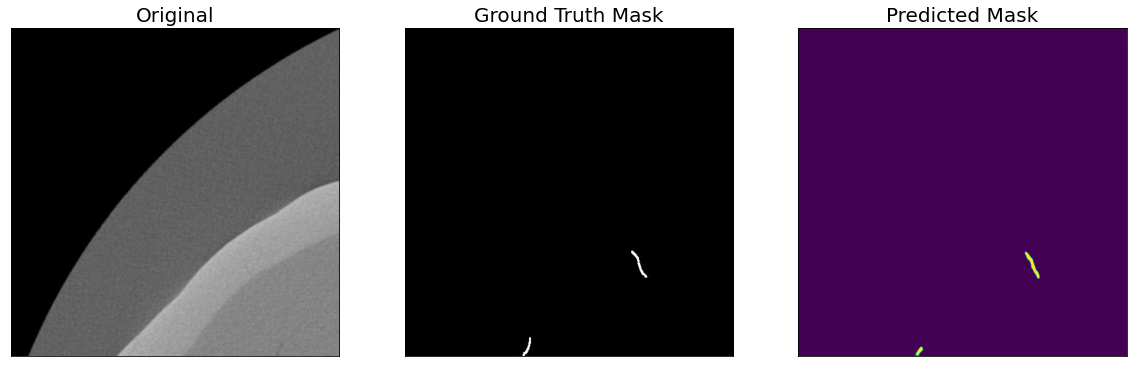

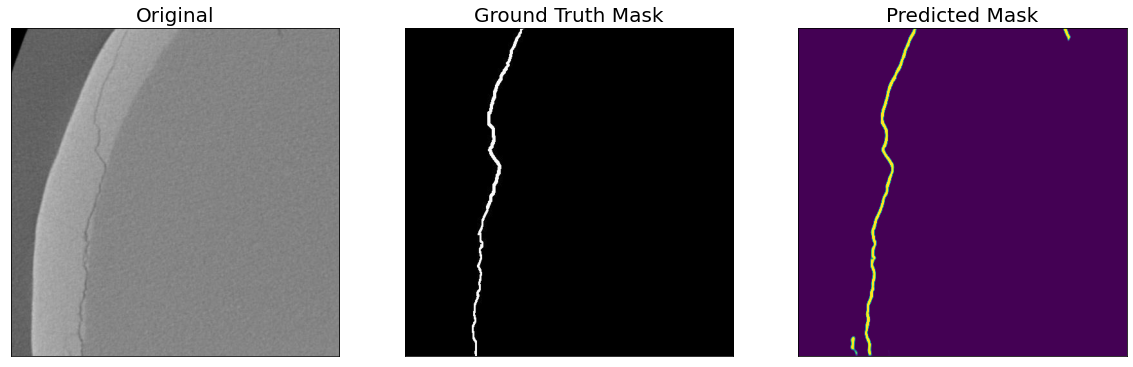

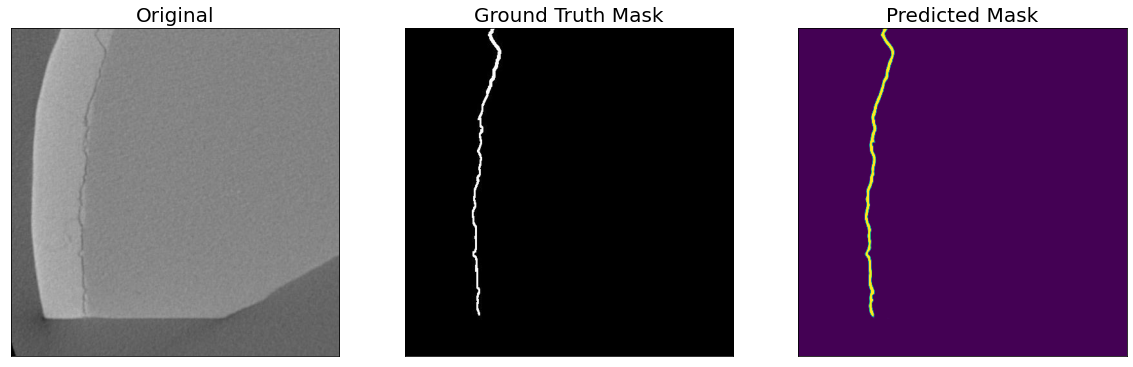

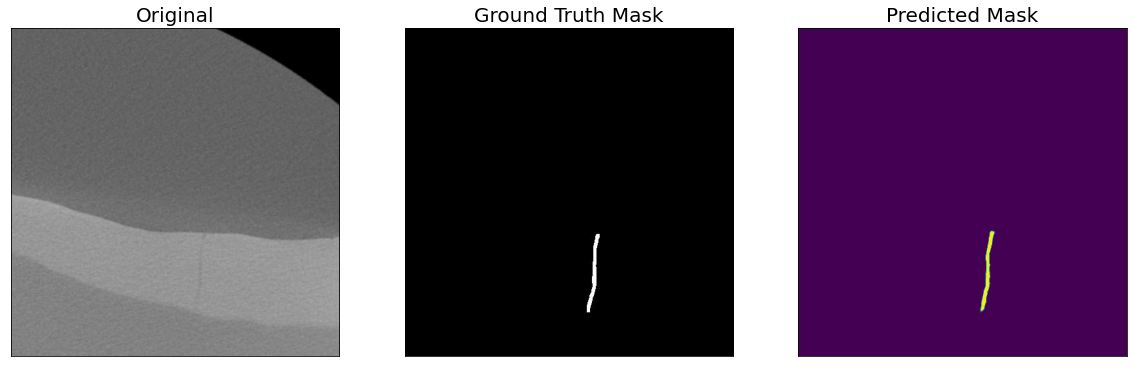

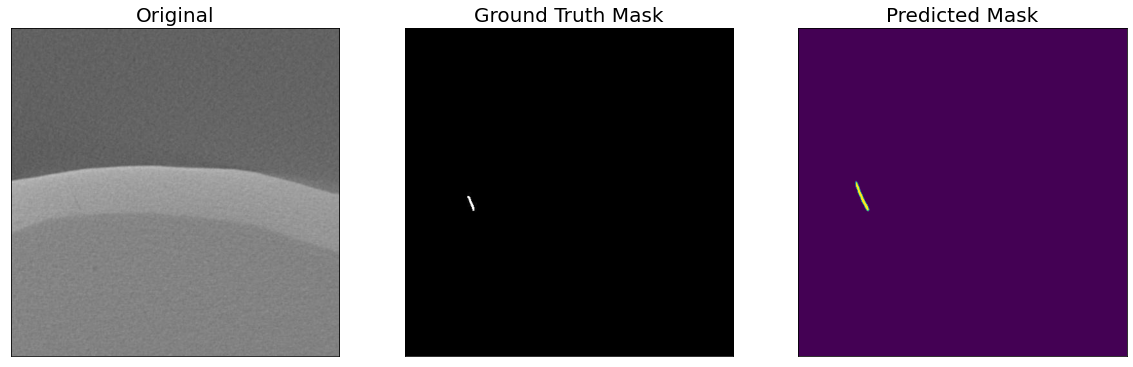

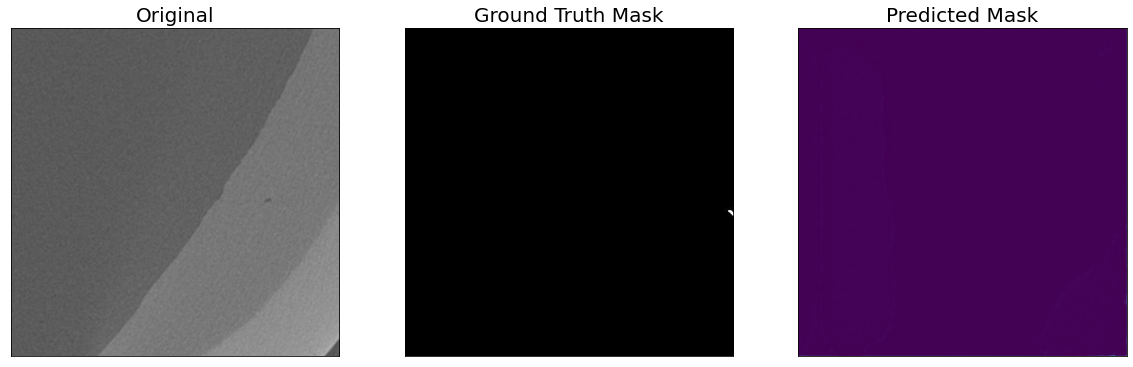

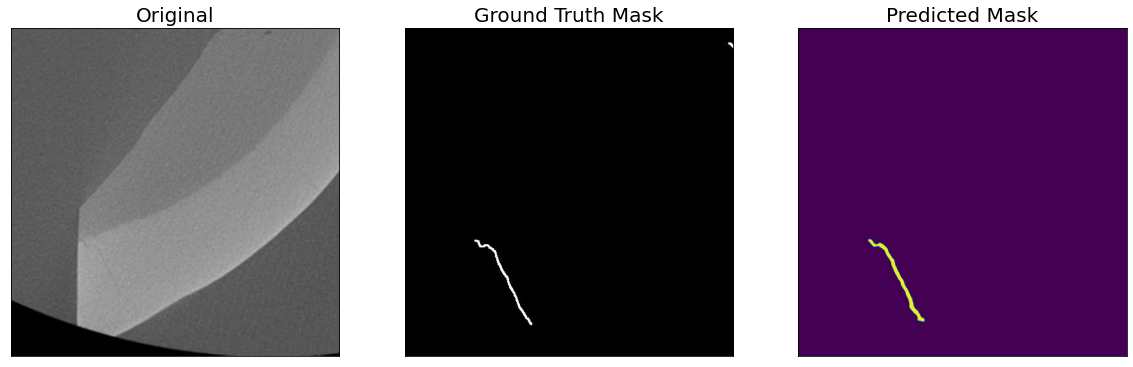

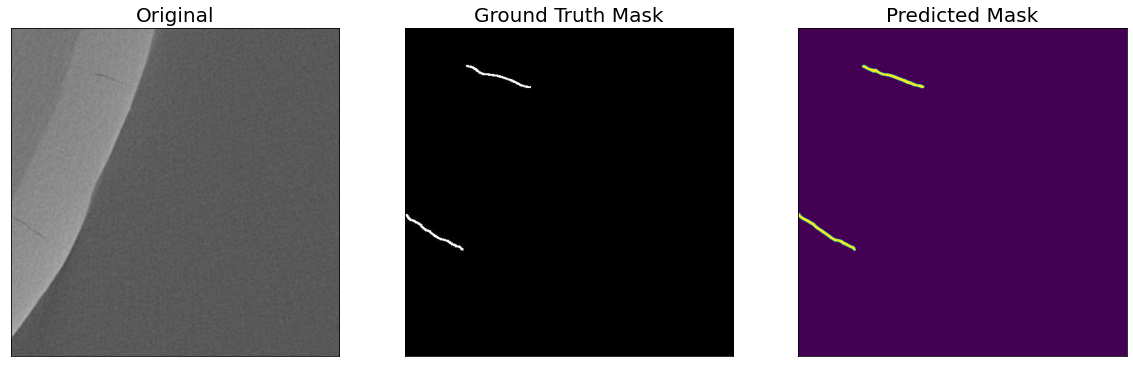

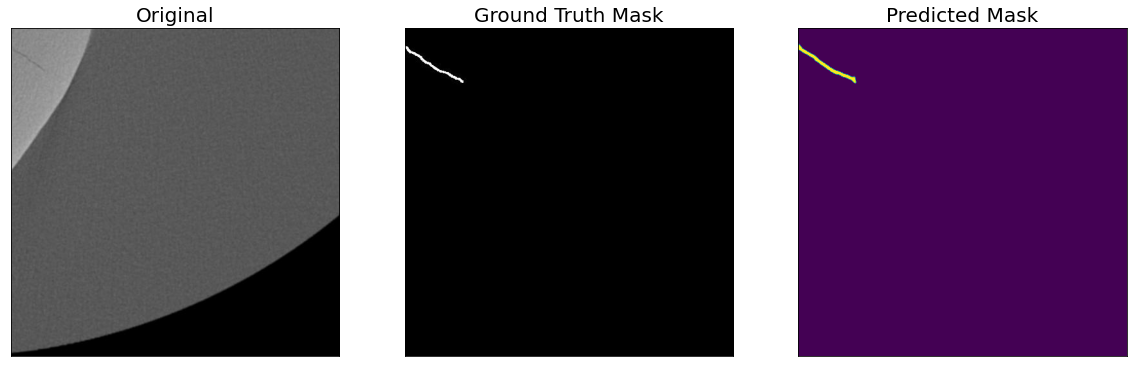

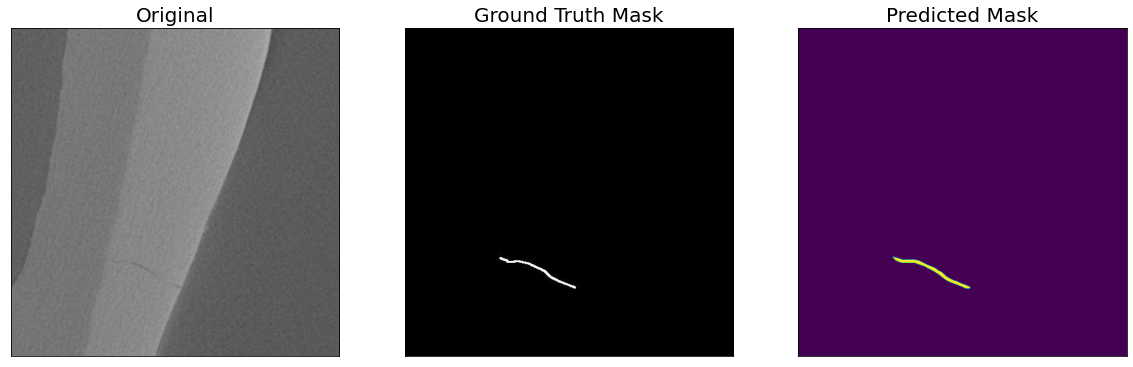

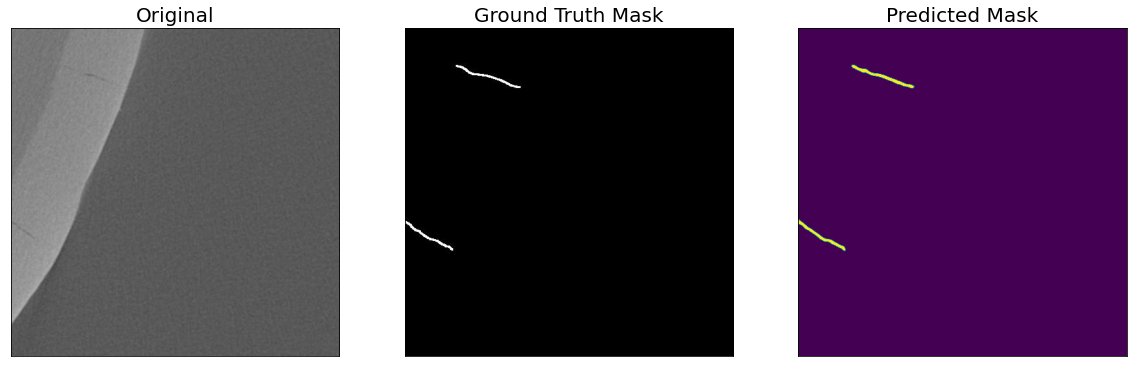

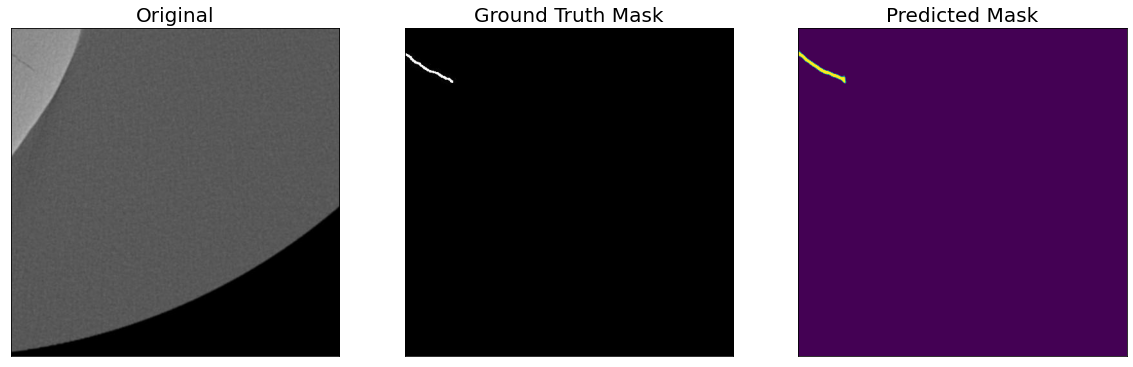

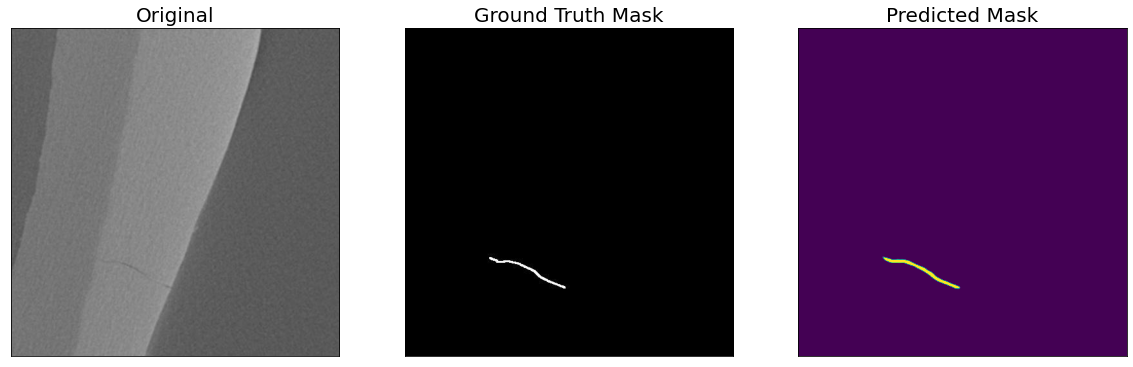

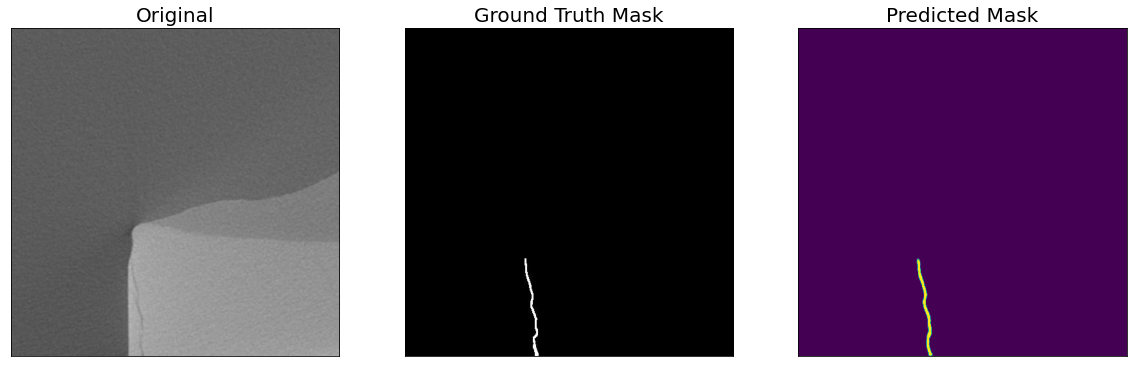

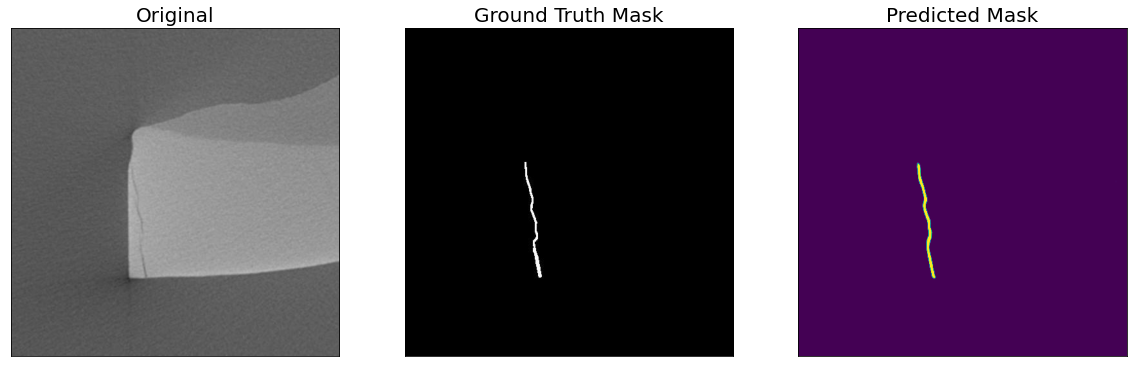

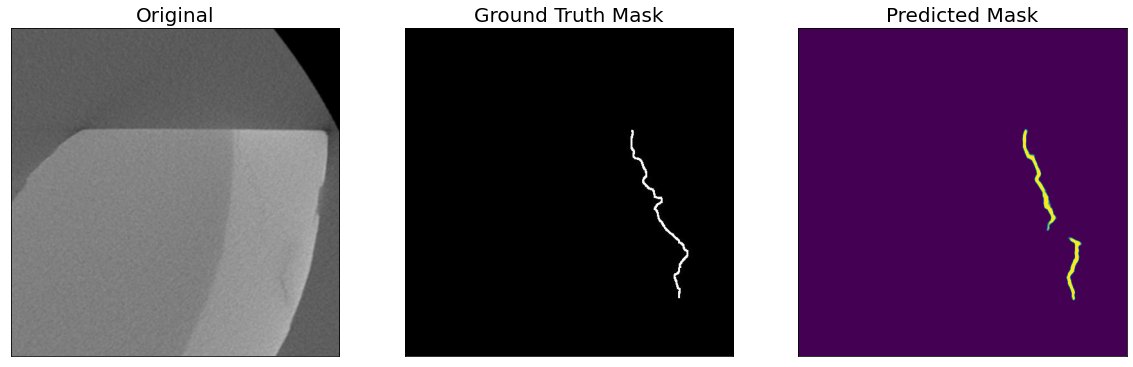

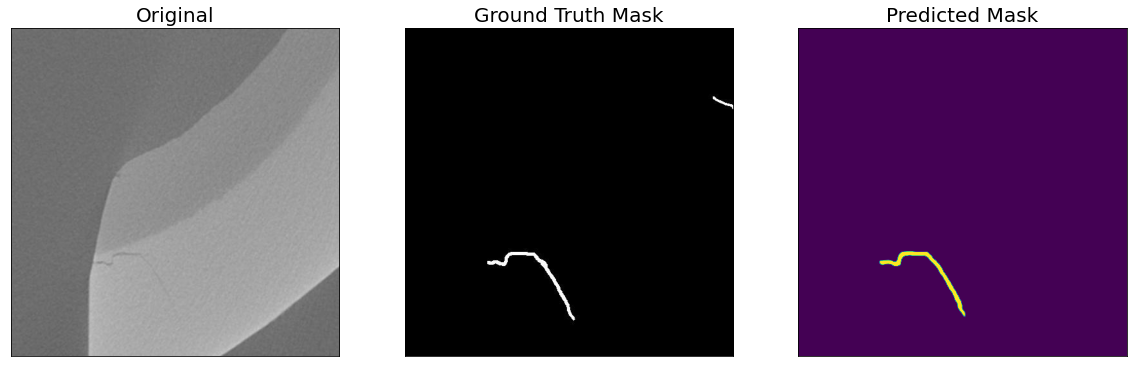

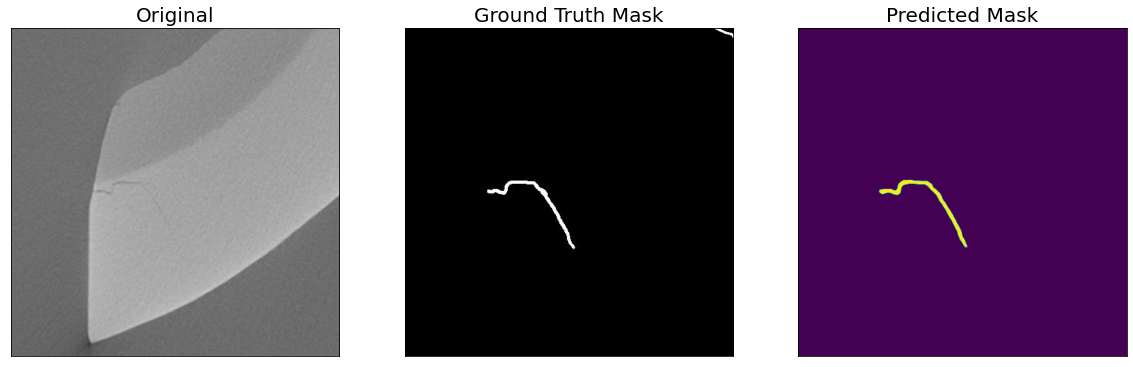

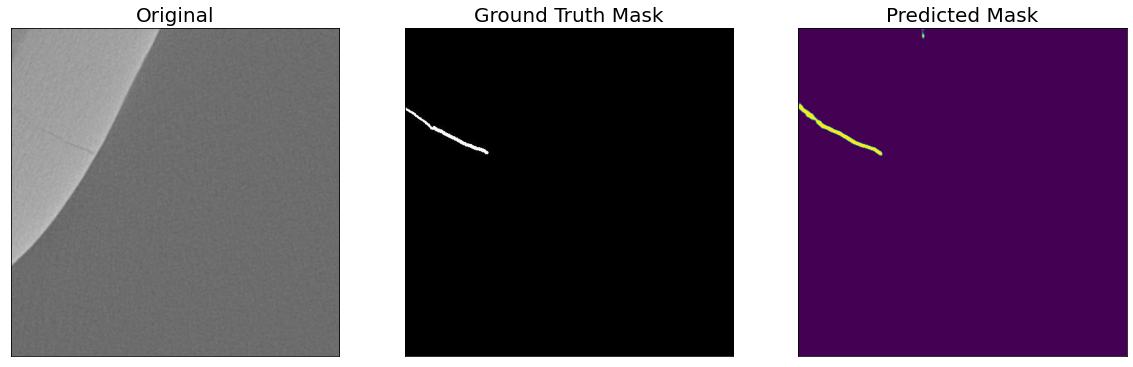

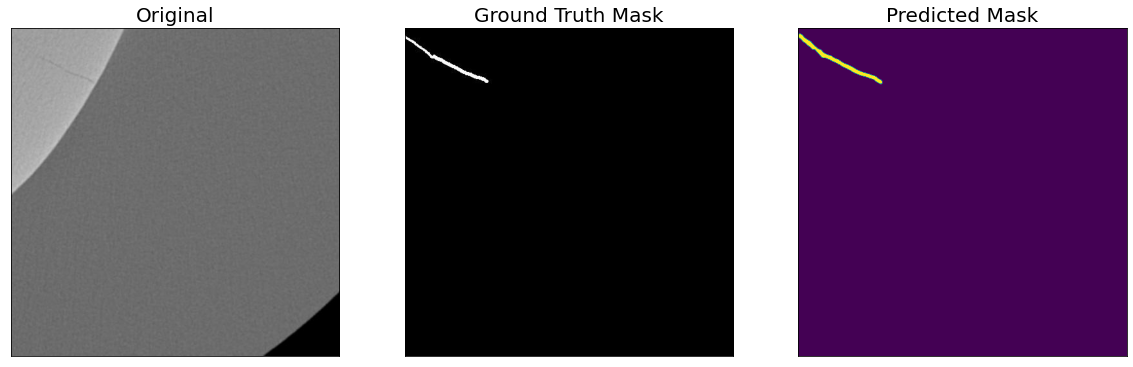

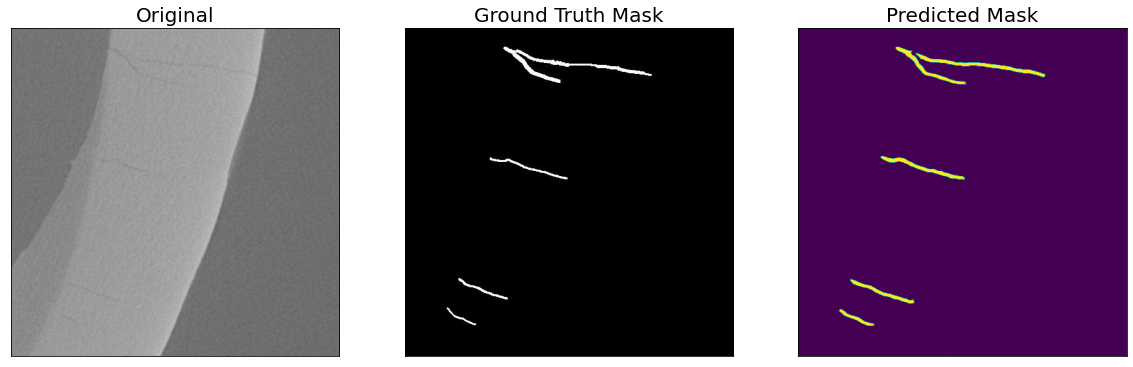

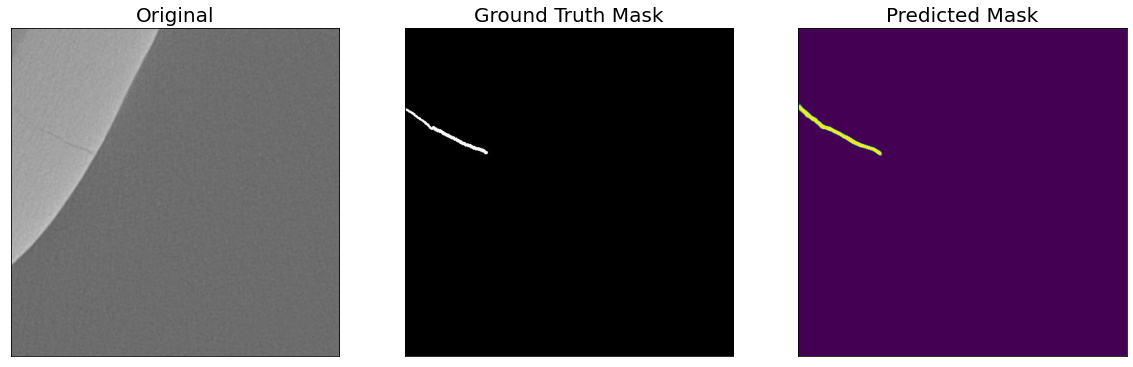

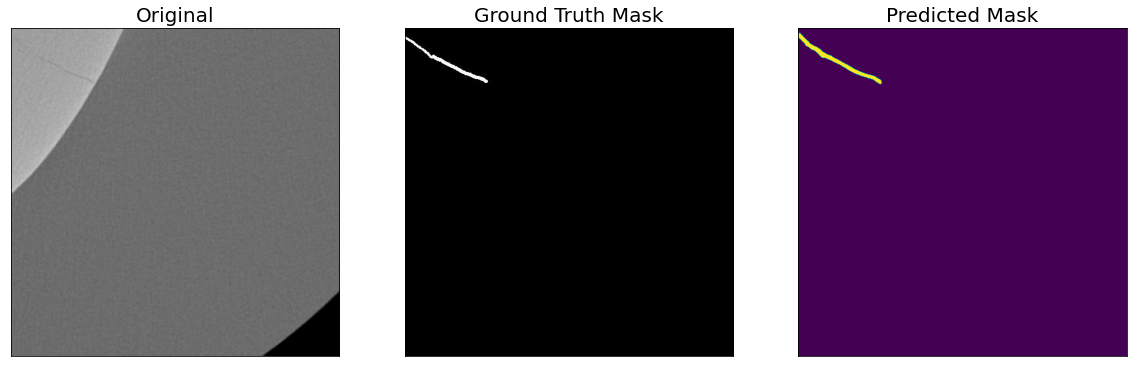

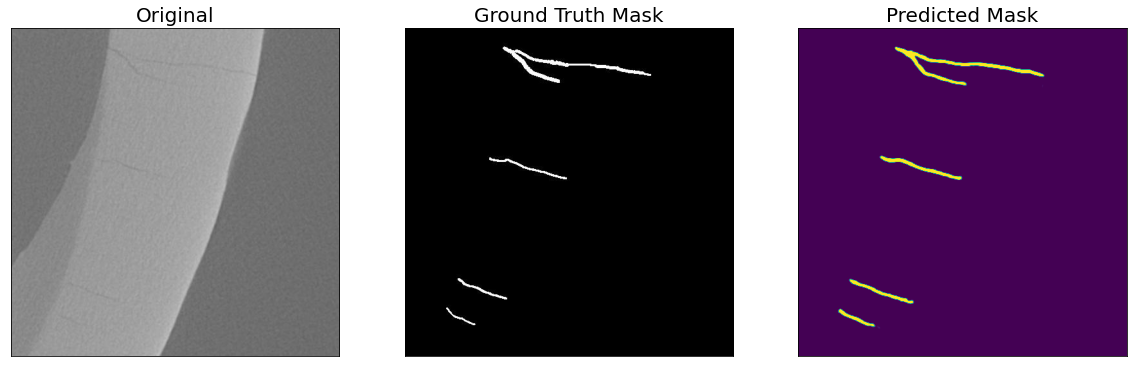

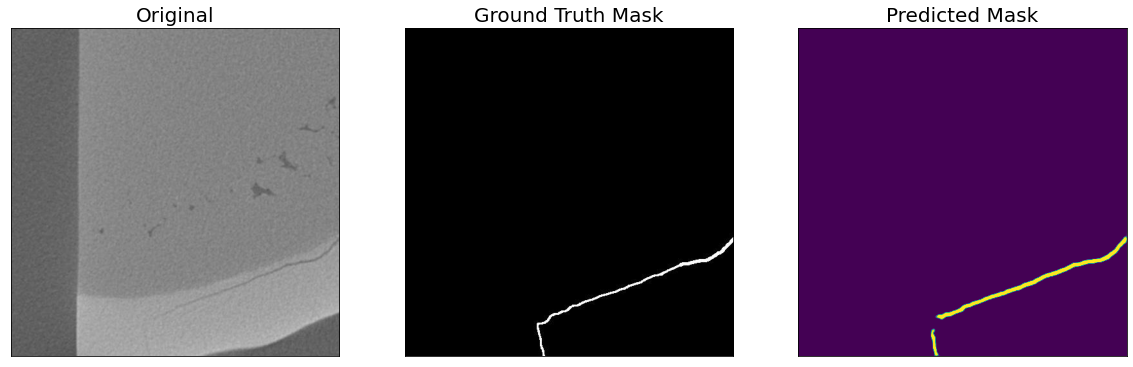

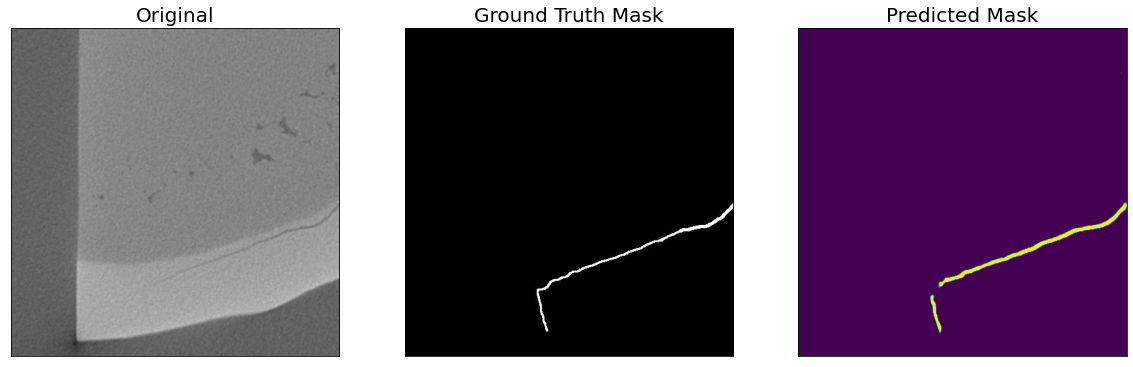

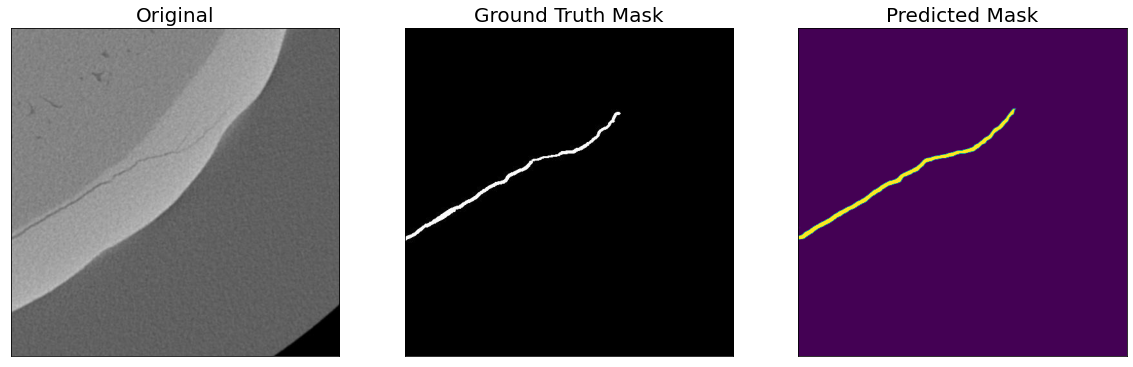

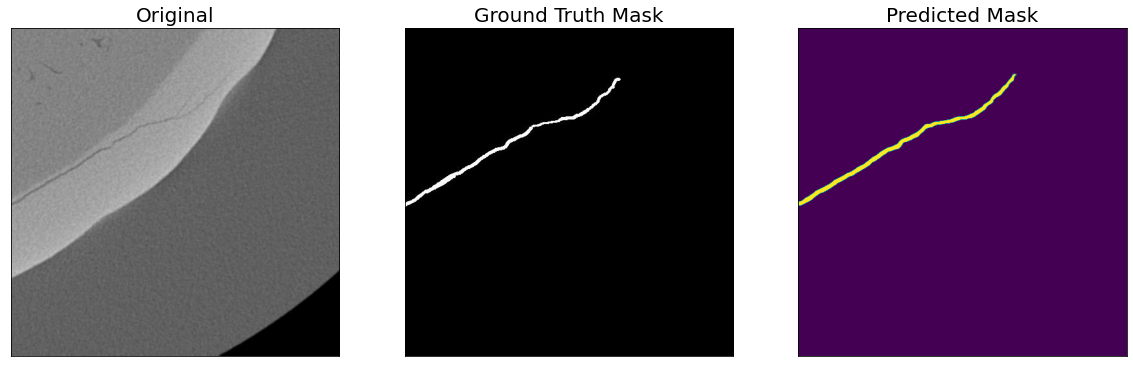

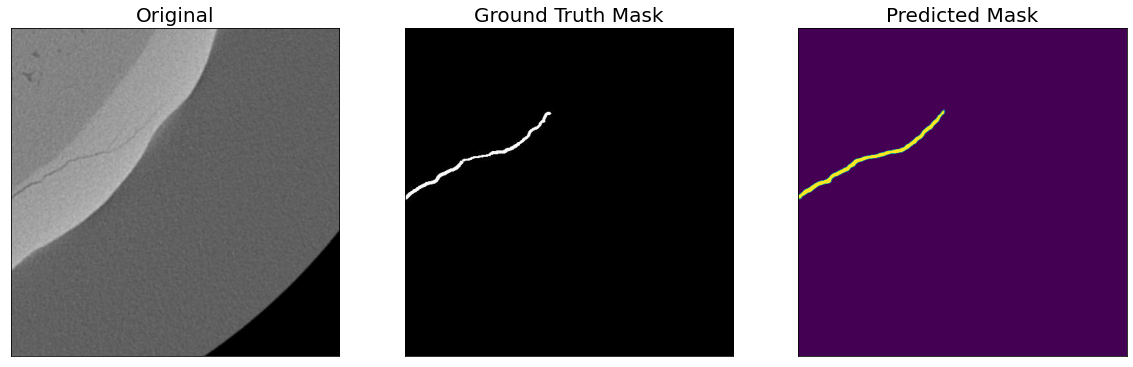

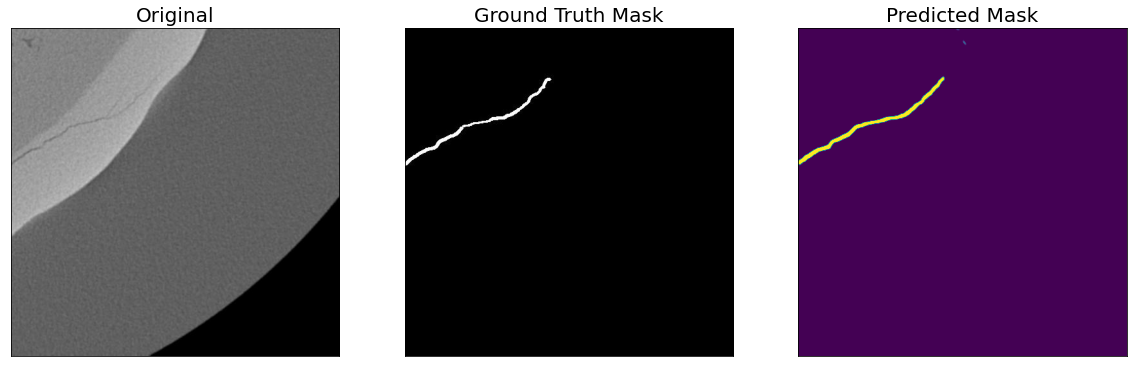

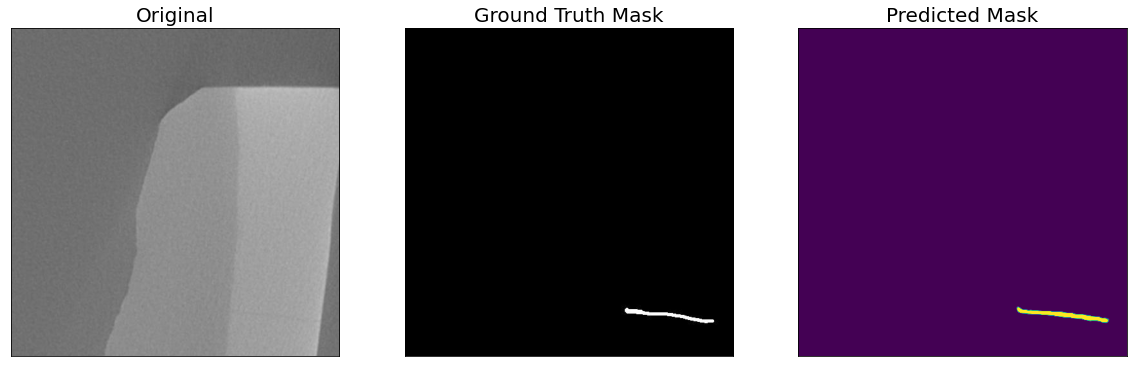

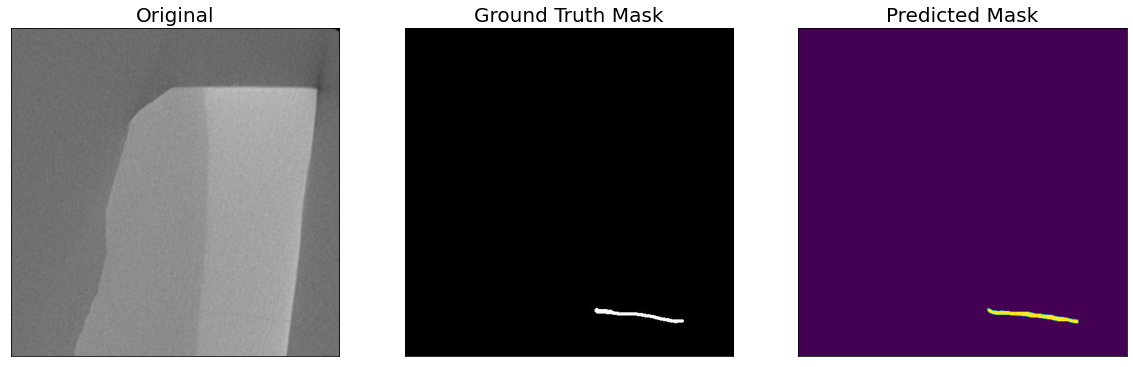

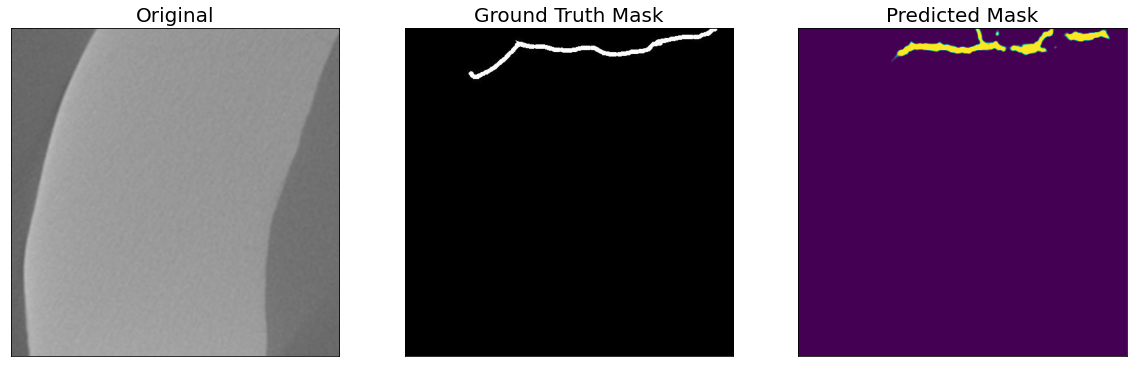

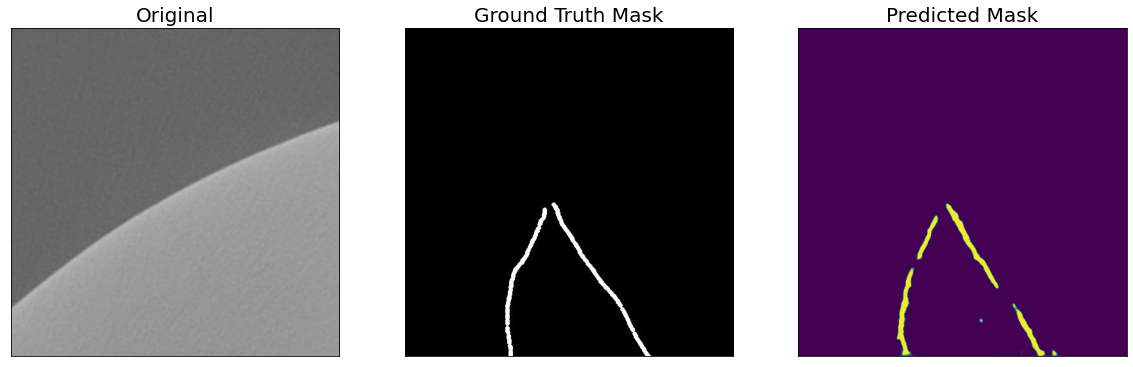

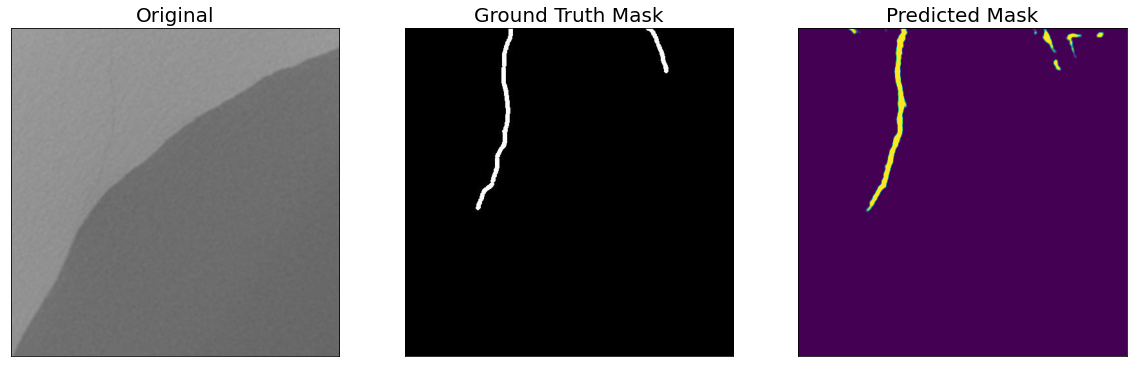

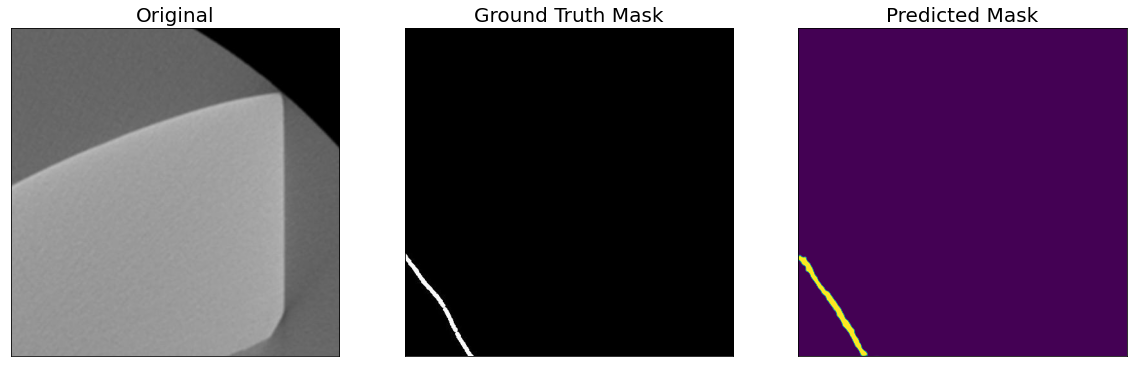

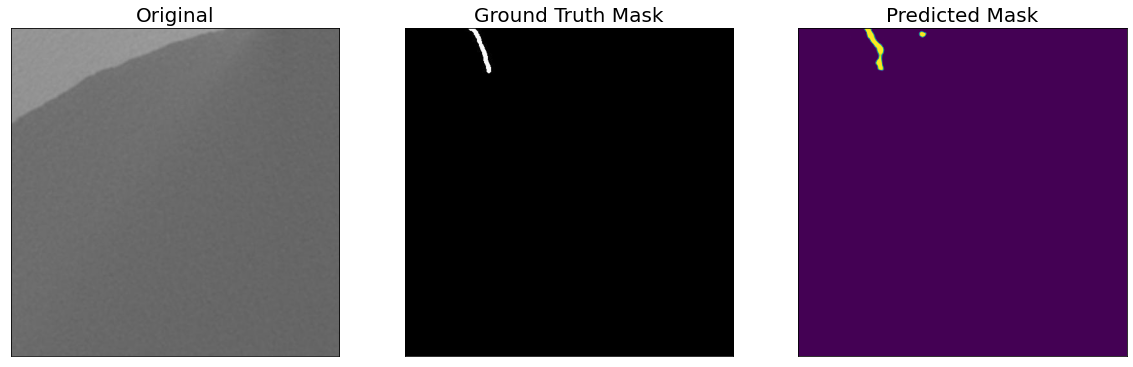

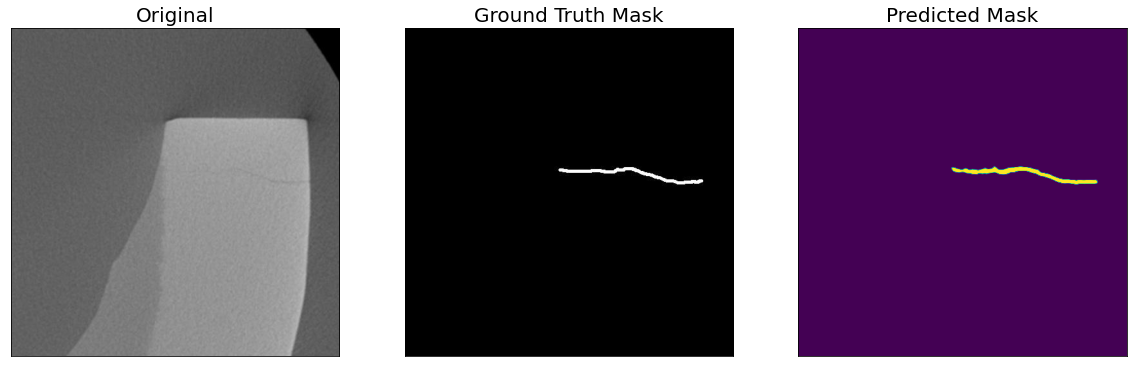

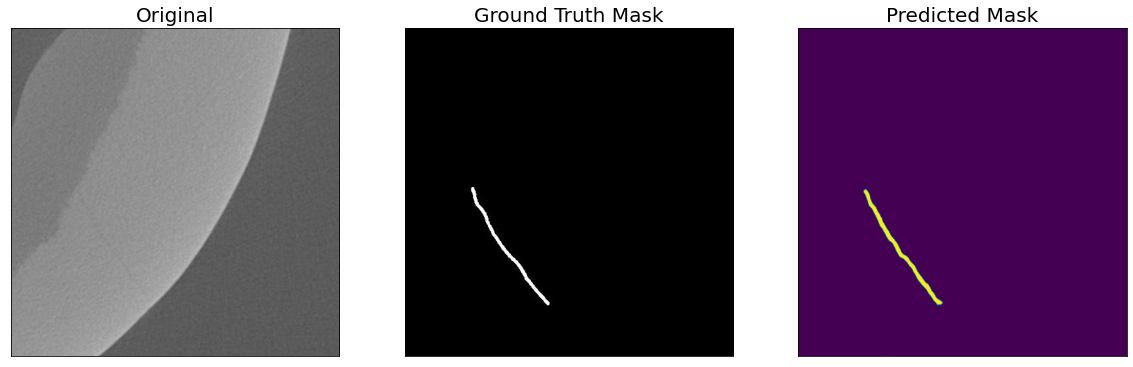

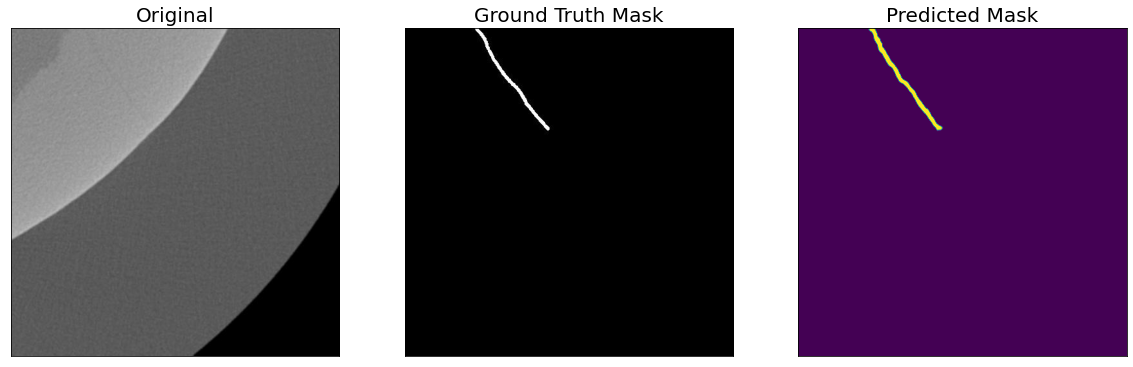

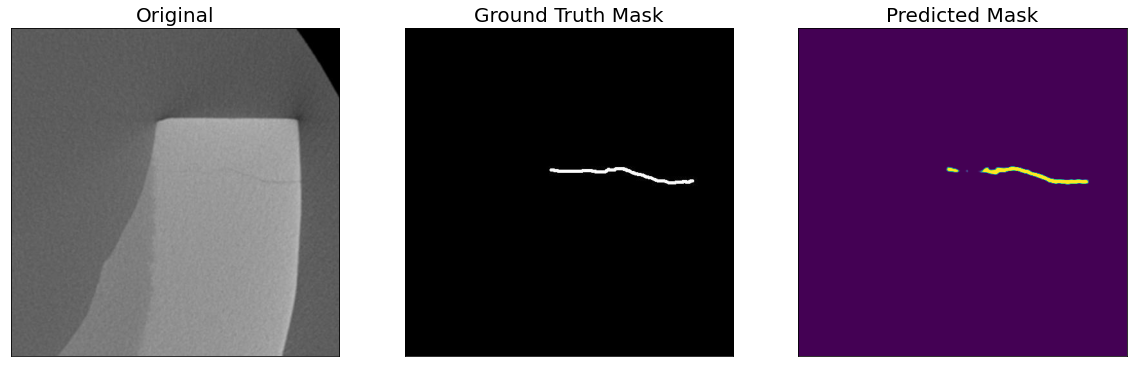

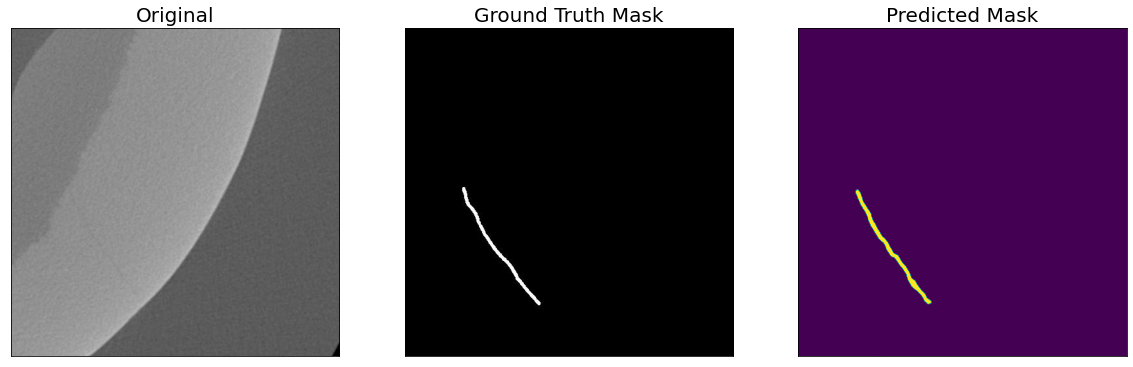

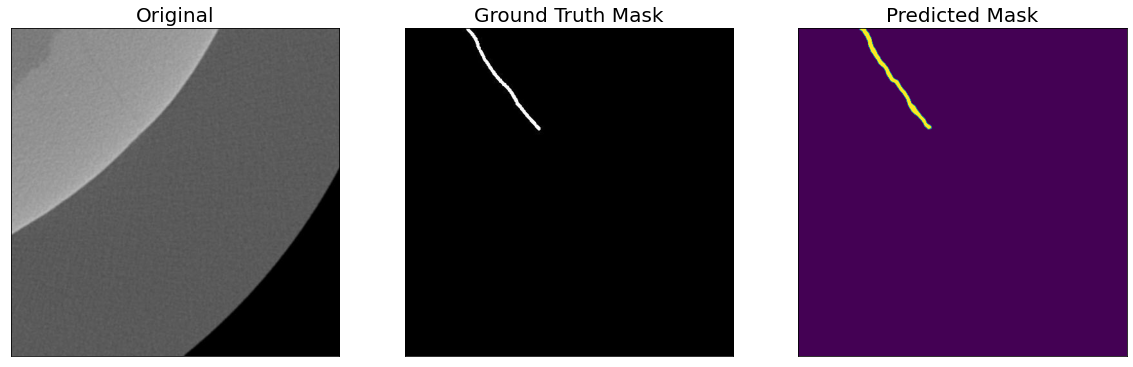

In [ ]:
for idx in range(len(valid_dataset)):
  image, gt_mask = valid_dataset[idx]

  image_tensor = image.unsqueeze(0).to(DEVICE)
  pred = best_model(image_tensor)
  pred = pred.detach().squeeze().cpu().numpy()

  visualize(
      original = transforms.ToPILImage()(image),
      ground_truth_mask = transforms.ToPILImage()(gt_mask),
      predicted_mask = pred
  )

In [ ]:
test_image_dir = path/"39-up-bm-jpg"
test_dataset = TestDataset(test_image_dir, test_transform)

In [ ]:
for idx in range(len(test_dataset)):
  image = test_dataset[idx]

  image_tensor = image.unsqueeze(0).to(DEVICE)
  pred = best_model(image_tensor)
  pred = pred.detach().squeeze().cpu().numpy()
  pred_file =f'{idx}.png'
  pred_im_path = f'/content/drive/My Drive/Colab Notebooks/Segmentation Tooth Cracks/39-up-bm-predictions/{pred_file}'
  cv2.imwrite(pred_im_path, 255*pred)

  original = transforms.ToPILImage()(image)
  original_file = f'{idx}.png'
  original_path = f'/content/drive/My Drive/Colab Notebooks/Segmentation Tooth Cracks/39-up-bm-padded/{original_file}'
  original.save(original_path)


  #visualize(
      #original = transforms.ToPILImage()(image),
      #predicted_mask = pred
  #)


